# Aprendizaje con Ensemble Avanzado, Transfer Learning y Evaluación de Modelos


### **Conjunto de Datos:**
Se trabajará con un conjunto de datos real sobre diabetes. Estos datos contienen varias variables clínicas que permiten predecir si un paciente tiene diabetes. Su primer paso será preparar los datos y realizar un análisis exploratorio. A continuación, comparará dos enfoques:

1. Utilizar las variables originales como descriptores.
2. Utilizar los principales componentes (PCs) obtenidos del Análisis de Componentes Principales (PCA) como descriptores.

Además, aplicará **Transfer Learning** utilizando un modelo de red neuronal preentrenado para mejorar el rendimiento de su mejor modelo.

Necesitaremos importar los siguientes módulos:

In [ ]:
# Upgrade pip to ensure compatibility
!pip install --upgrade pip --quiet # Keep active

# Install required libraries with quiet output
!pip install scikit-learn tensorflow keras-tuner --quiet  # Keep active

In [ ]:
!pip install keras-tuner --quiet
!pip install imbalanced-learn --quiet

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam

# Ensure that plots are displayed inline (especially useful for Jupyter Notebooks and Colab)
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

work_dir = '/content/drive/My Drive/Workspace'

# Crear el directorio si no existe
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

# Cambiar al directorio de trabajo
os.chdir(work_dir)

# Mostrar los archivos en el directorio
print("Archivos en el directorio:")
print(os.listdir(work_dir))

Archivos en el directorio:
['diabetes.csv']


### **1. Preparación de Datos y Análisis Exploratorio (EDA)**

- 1.1. Cargad el conjunto de datos sobre diabetes.

In [ ]:
file_name = "diabetes.csv"
data = pd.read_csv(file_name)

print("Datos:")
print(data.head())

print(f"\nNúmero de filas y columnas: {data.shape}")

print("\nInformación del dataset:")
print(data.info())

Datos:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Número de filas y columnas: (768, 9)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies  

In [ ]:
# Valores únicos en cada columna
print("\nValores únicos por columna:")
for col in data.columns:
    unique_values = data[col].unique()
    print(f"{col}: {len(unique_values)} valores únicos")


Valores únicos por columna:
Pregnancies: 17 valores únicos
Glucose: 136 valores únicos
BloodPressure: 47 valores únicos
SkinThickness: 51 valores únicos
Insulin: 186 valores únicos
BMI: 248 valores únicos
DiabetesPedigreeFunction: 517 valores únicos
Age: 52 valores únicos
Outcome: 2 valores únicos


<b>Categóricas:</b>

  - Outcome: Variable de clase binaria (0: no diabetes, 1: diabetes). Es categórica aunque esté codificada como un número.

<b>Numéricas:</b>

  - Pregnancies: Número de embarazos.
  - Glucose: Concentración de glucosa.
  - BloodPressure: Presión arterial.
  - SkinThickness: Grosor del pliegue cutáneo.
  - Insulin: Insulina.
  - BMI: Índice de masa corporal.
  - DiabetesPedigreeFunction: Función de pedigrí de diabetes.
  - Age: Edad en años.

- 1.2. Análisis estadístico básico.

In [ ]:
print("Resumen estadístico básico")
print(data.describe())

print("\nValores nulos")
print(data.isnull().sum())

Resumen estadístico básico
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min     

- 1.3. Análisis exploratorio de datos (EDA) con visualizaciones para entender la distribución y correlación.  
1.3.1. Análisis de Variables Categóricas

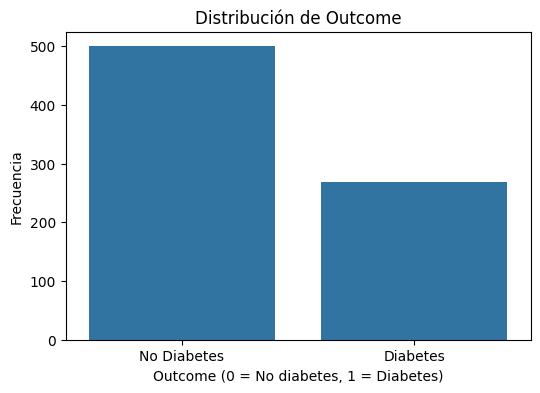

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Outcome')
plt.title("Distribución de Outcome")
plt.xlabel("Outcome (0 = No diabetes, 1 = Diabetes)")
plt.ylabel("Frecuencia")
plt.xticks([0, 1], ["No Diabetes", "Diabetes"])
plt.show()

1.3.2. Análisis de Variables Numéricas

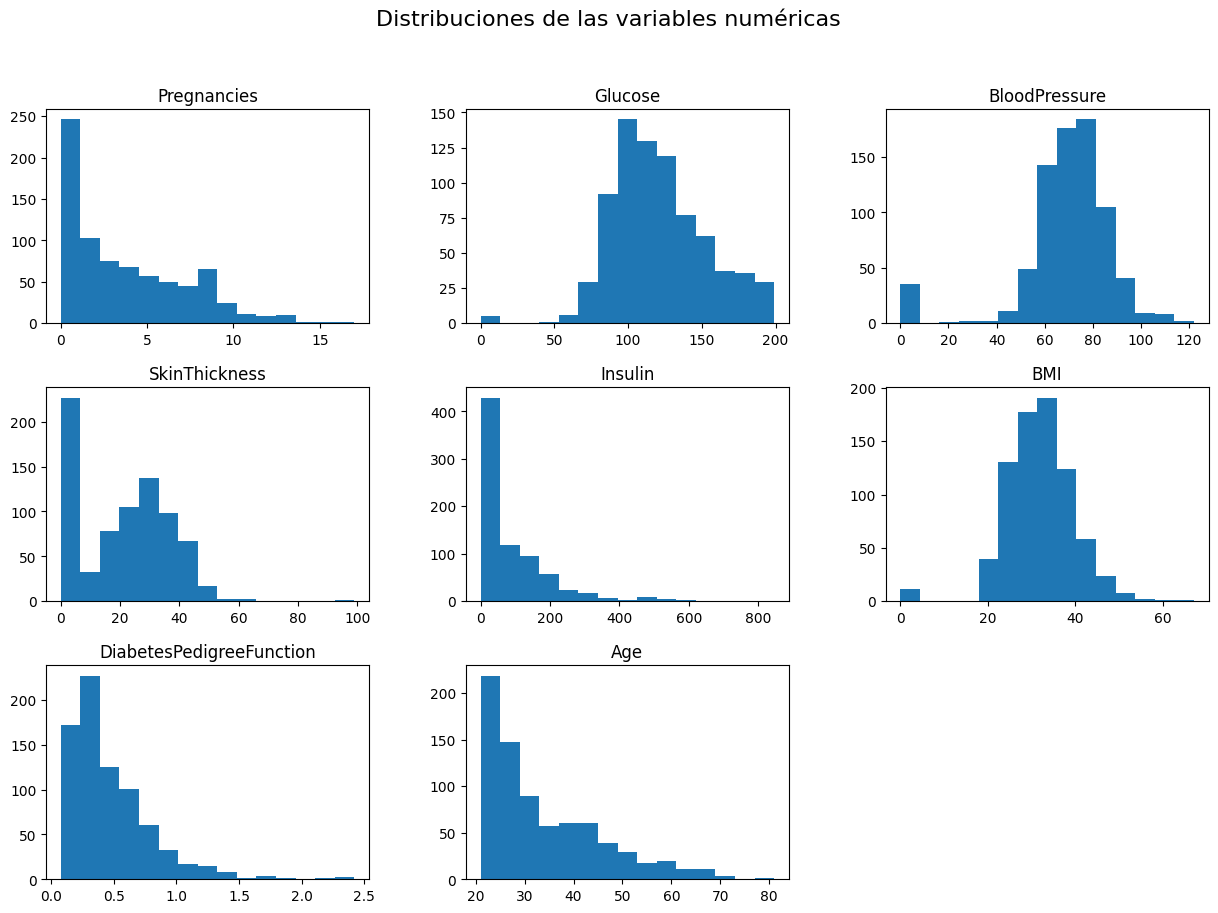

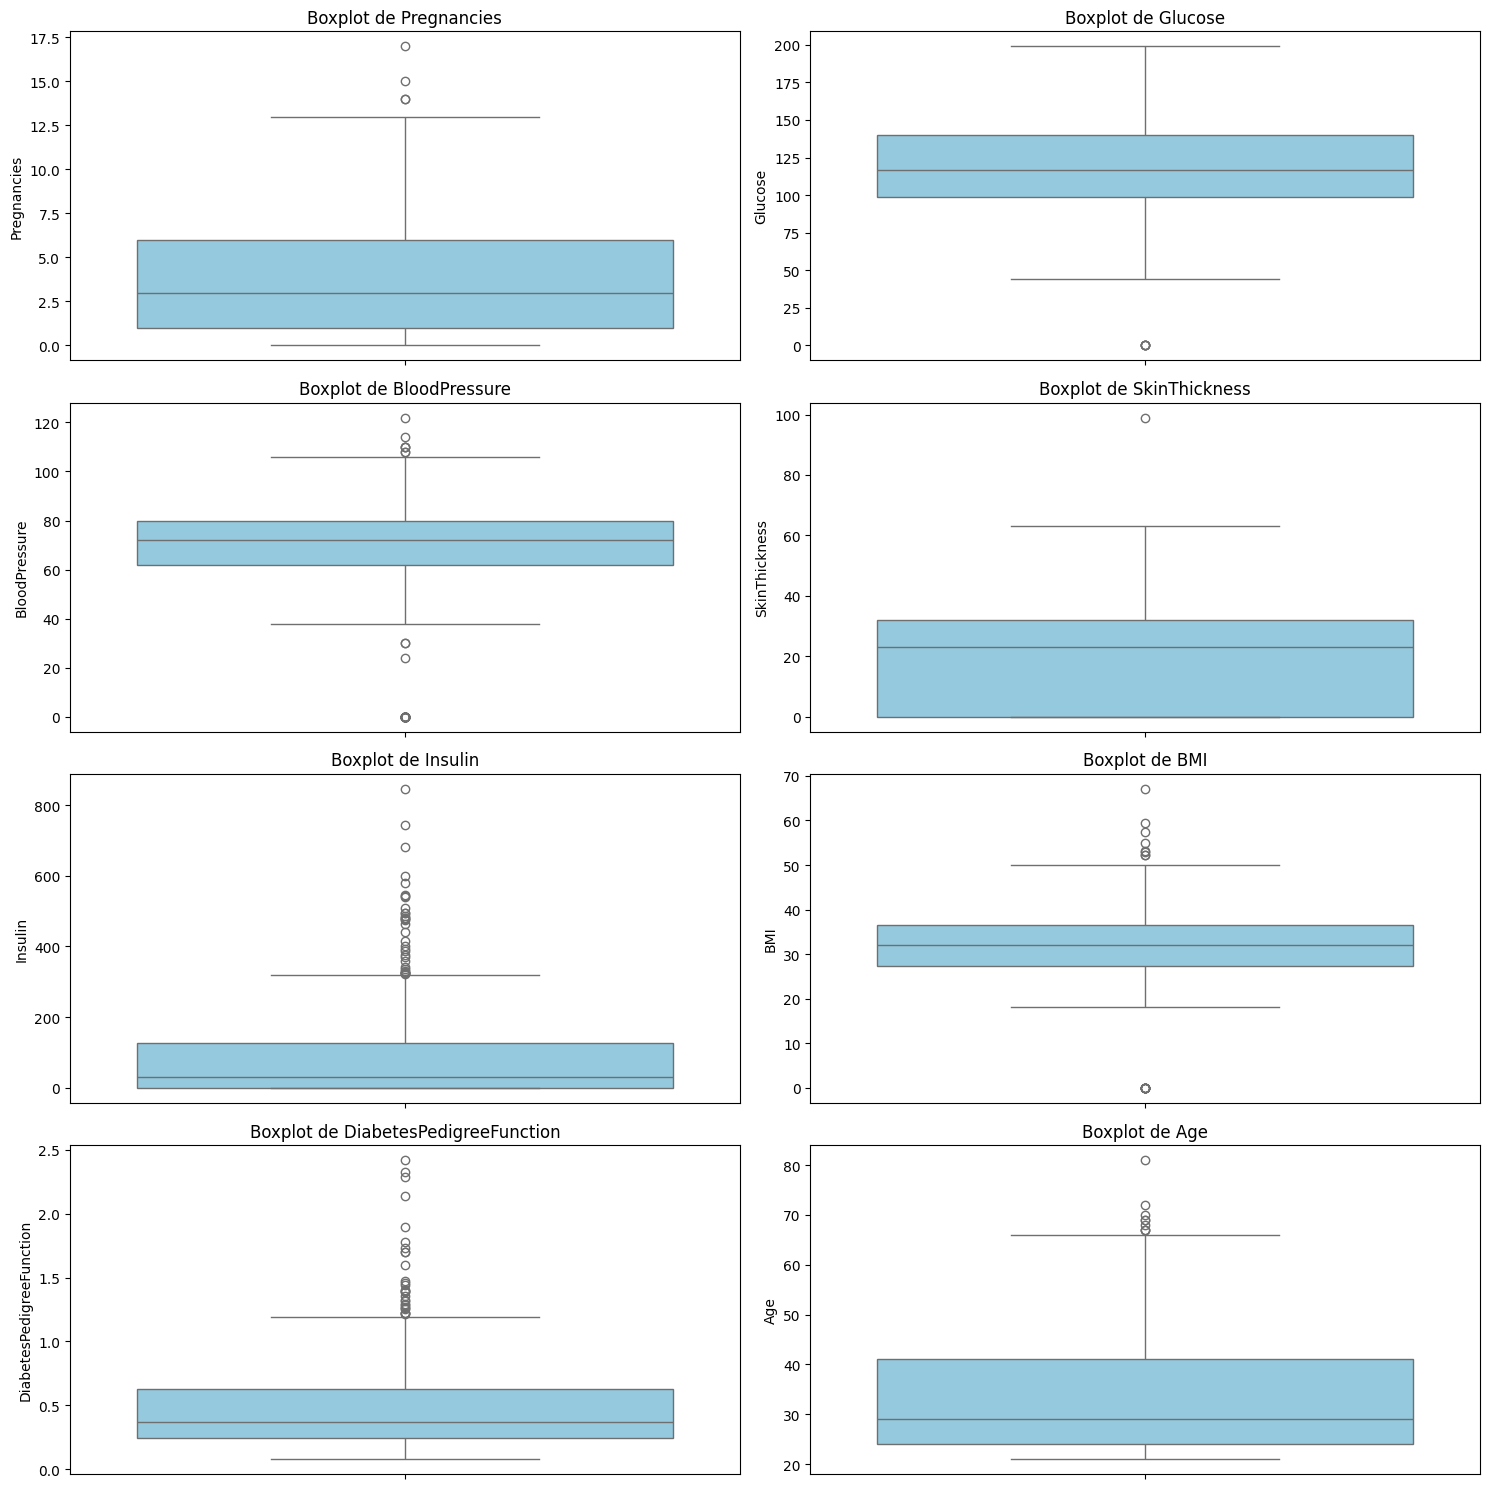

In [ ]:
numerical_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                     'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

data[numerical_columns].hist(bins=15, figsize=(15, 10), grid=False)
plt.suptitle("Distribuciones de las variables numéricas", fontsize=16)
plt.show()

plt.figure(figsize=(15, 15))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=data, y=col, color="skyblue")
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()


<b> Histograma: </b>

- Pregnancies: Distribución sesgada hacia la izquierda, con la mayoría de los valores cercanos a 0.

- Glucose: Distribución aproximadamente normal, aunque hay valores cercanos a 0 que pueden ser erróneos.

- BloodPressure: La mayoría de los valores están alrededor de 70-80, pero hay ceros que podrían ser datos faltantes.

- SkinThickness: Similar a las anteriores, hay valores cercanos a 0.

- Insulin: Alta variabilidad con valores extremos hacia la derecha. Los ceros también necesitan revisión.

- BMI: Distribución normal, aunque hay valores en 0.

- DiabetesPedigreeFunction: Distribución sesgada hacia la derecha.

- Age: Distribución sesgada hacia la derecha, con más personas en el rango de 20-40 años.

<b> Boxplots: </b>

- Confirman la presencia de valores atípicos en varias variables.

- Los ceros en variables como Glucose, BloodPressure, SkinThickness, Insulin y BMI deben investigarse como posibles datos faltantes.



1.3.3. Matriz de Correlación

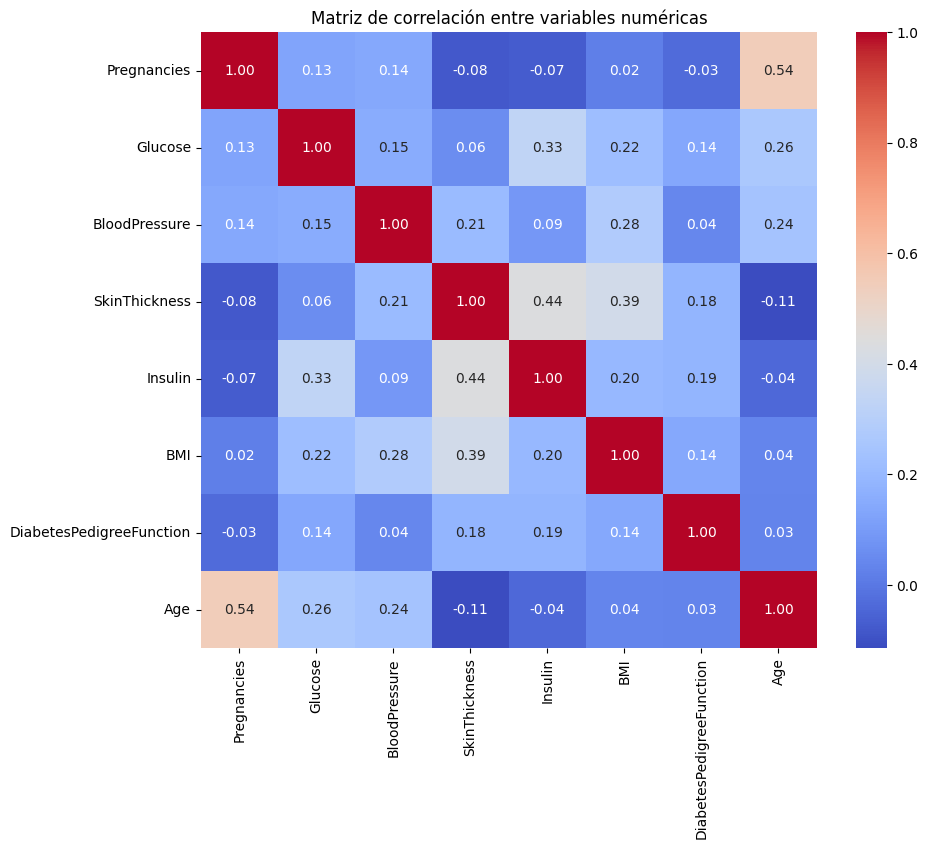

In [ ]:
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

<b> Matriz de correlación: </b>

- Age y Pregnancies tienen la correlación más alta (0.54), lo cual es esperable.

- Glucose tiene una correlación moderada con Insulin (0.33), lo que podría indicar una relación relevante para la diabetes.

- Otras correlaciones son bajas, lo que sugiere que muchas variables contribuyen de forma independiente.

- 1.4. Preprocesamiento de datos:

In [ ]:
# Definimos las columnas en donde los ceros deben ser tratados como valores faltantes y sustitumos los ceros por valores nulos
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[columns_with_zeros] = data[columns_with_zeros].replace(0, np.nan)

print("\n--- Valores faltantes tras sustituir ceros ---")
print(data.isnull().sum())


# Imputamos los valores faltantes con la mediana de cada columna
for col in columns_with_zeros:
    data[col] = data[col].fillna(data[col].median())

print("\n--- Comprobación tras la imputación ---")
print(data.isnull().sum())


--- Valores faltantes tras sustituir ceros ---
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

--- Comprobación tras la imputación ---
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


- 1.5. Balanceo de clases


--- Distribución de clases (frecuencia) ---
Outcome
0    500
1    268
Name: count, dtype: int64

--- Distribución de clases (porcentaje) ---
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


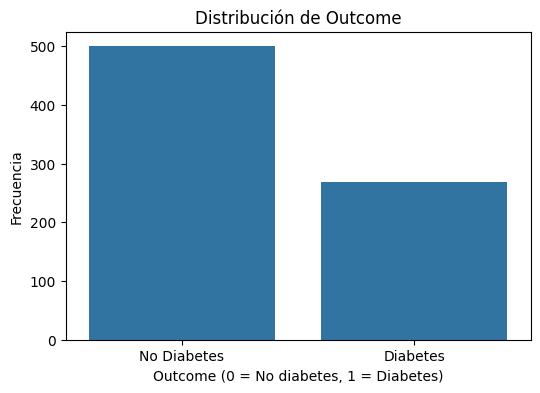

In [ ]:
# Verificamos la frecuencia de cada clase
class_distribution = data['Outcome'].value_counts()
print("\n--- Distribución de clases (frecuencia) ---")
print(class_distribution)

# Calculamos el porcentaje de cada clase
class_percentage = data['Outcome'].value_counts(normalize=True) * 100
print("\n--- Distribución de clases (porcentaje) ---")
print(class_percentage)

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Outcome')
plt.title("Distribución de Outcome")
plt.xlabel("Outcome (0 = No diabetes, 1 = Diabetes)")
plt.ylabel("Frecuencia")
plt.xticks([0, 1], ["No Diabetes", "Diabetes"])
plt.show()

Dado que tenemos previsto utilizar redes neuronales y transferencia de aprendizaje o transfer learning (que puede gestionar bien grandes conjuntos de datos), el mejor método sería una combinación de **SMOTE** y **ADASYN**:

- Primero utiliza **SMOTE**. Ayudará a crear un conjunto de datos equilibrado con muestras sintéticas (random_state=42).  
- Después **ADASYN**. Perfeccionará aún más los datos sintéticos, centrándose en las muestras desafiantes (random_state=42).


--- Distribución inicial de clases ---
Counter({0: 500, 1: 268})

--- Distribución tras SMOTE ---
Counter({1: 500, 0: 500})

--- Distribución tras ADASYN ---
Counter({1: 500, 0: 500})


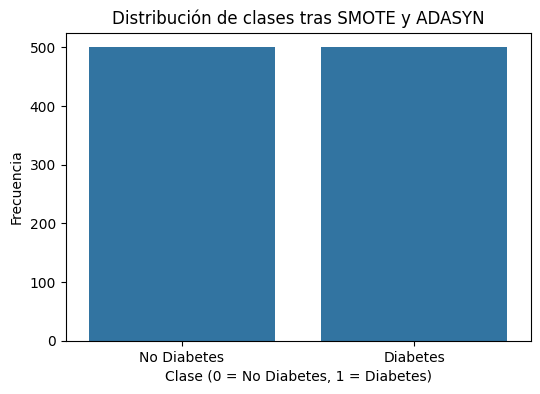

In [ ]:
from collections import Counter

X = data.drop('Outcome', axis=1)
y = data['Outcome']

print("\n--- Distribución inicial de clases ---")
print(Counter(y))

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("\n--- Distribución tras SMOTE ---")
print(Counter(y_smote))

adasyn = ADASYN(random_state=42)
X_balanced, y_balanced = adasyn.fit_resample(X_smote, y_smote)

print("\n--- Distribución tras ADASYN ---")
print(Counter(y_balanced))

plt.figure(figsize=(6, 4))
sns.countplot(x=y_balanced)
plt.title("Distribución de clases tras SMOTE y ADASYN")
plt.xlabel("Clase (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Frecuencia")
plt.xticks([0, 1], ["No Diabetes", "Diabetes"])
plt.show()

In [ ]:
balanced_data = pd.DataFrame(X_balanced, columns=X.columns)
balanced_data['Outcome'] = y_balanced

print("\n--- Primeras filas del DataFrame balanceado ---")
print(balanced_data.head())


--- Primeras filas del DataFrame balanceado ---
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


### **2. Reducción de Dimensionalidad**

Utilizaremos **Análisis de Componentes Principales (PCA)** para mejorar la información de los pacientes diabéticos con el objetivo de facilitar la separación en el modelo de clasificación. Nuestro objetivo es garantizar que el modelo PCA capture patrones útiles para distinguir mejor a los pacientes diabéticos de los no diabéticos.

**Riesgos de Overfitting y Cómo Evitarlos:**

Cuando construimos el modelo PCA solo con pacientes diabéticos, puede existir el riesgo de que los componentes principales capturen patrones específicos de este grupo y no se generalicen bien para los pacientes no diabéticos. Para mitigar este riesgo, seguiremos un enfoque robusto con **validación cruzada**, el cual:

1. **Reduce el sobreajuste**, evaluando la estabilidad de los componentes principales a través de diferentes particiones de datos de pacientes diabéticos.
2. **Garantiza una mejor generalización**, ya que seleccionamos un conjunto estable de componentes mediante la **promediación de las cargas** de los componentes principales a través de los diferentes pliegues (folds) de la validación cruzada.

### **Proceso Que Vamos A Seguir**

1. **Preparación:** Se separan los pacientes diabéticos para el entrenamiento del PCA. Divide los datos diabéticos en entrenamiento/validación (80%) y pruebas (20%), random_state=42.
2. **Normalización y Validación Cruzada para el PCA:** Utilizamos validación cruzada (n_splits=5, shuffle=True, random_state=42) para normalizar los datos y evaluar la consistencia de los componentes principales.
3. **Promediación de los Componentes Principales:** Se promedian las cargas de los componentes principales para obtener un conjunto estable.
4. **Proyección de los Datos Restantes:** Utilizamos los componentes estables para proyectar tanto los datos de test de los pacientes diabéticos como los datos de los pacientes no diabéticos.
5. **Creación del Conjunto de Entrenamiento para Clasificación:** El conjunto de datos proyectado se utiliza como entrada para los modelos de clasificación.

Este enfoque garantiza que el modelo PCA no sobreajuste a los pacientes diabéticos utilizados para construirlo, y nos permite utilizar descriptores coherentes para todo el conjunto de datos. Esto mejora la robustez del modelo de clasificación, minimizando el riesgo de sesgo y mejorando la separación de los pacientes en base a sus características proyectadas.

- 2.1. Preparación.

In [ ]:
diabetic_data = balanced_data[balanced_data['Outcome'] == 1]

X_diabetic = diabetic_data.drop('Outcome', axis=1)
y_diabetic = diabetic_data['Outcome']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_diabetic, y_diabetic, test_size=0.2, random_state=42
)

print("\n--- Dimensiones del conjunto de datos ---")
print(f"Entrenamiento/Validación: {X_train_val.shape}")
print(f"Pruebas: {X_test.shape}")


--- Dimensiones del conjunto de datos ---
Entrenamiento/Validación: (400, 8)
Pruebas: (100, 8)


- 2.2. Normalización y construcción del modelo PCA

In [ ]:
# Normalizamos de los datos
scaler = StandardScaler()
X_train_val_normalized = scaler.fit_transform(X_train_val)

pca = PCA(n_components=0.95)  # Retenemos el 95% de la varianza
X_train_val_pca = pca.fit_transform(X_train_val_normalized)

print("\n--- PCA aplicado al conjunto de entrenamiento/validación ---")
print(f"Componentes principales retenidos: {pca.n_components_}")
print(f"Varianza explicada por los componentes: {pca.explained_variance_ratio_}")
print(f"Suma de la varianza explicada: {sum(pca.explained_variance_ratio_):.2f}")


--- PCA aplicado al conjunto de entrenamiento/validación ---
Componentes principales retenidos: 7
Varianza explicada por los componentes: [0.23401482 0.19509686 0.15691411 0.12188166 0.10255328 0.07432271
 0.06658451]
Suma de la varianza explicada: 0.95


El PCA seleccionó los 7 componentes principales que mejor representan la información en los datos mientras retiene el 95% de la varianza.

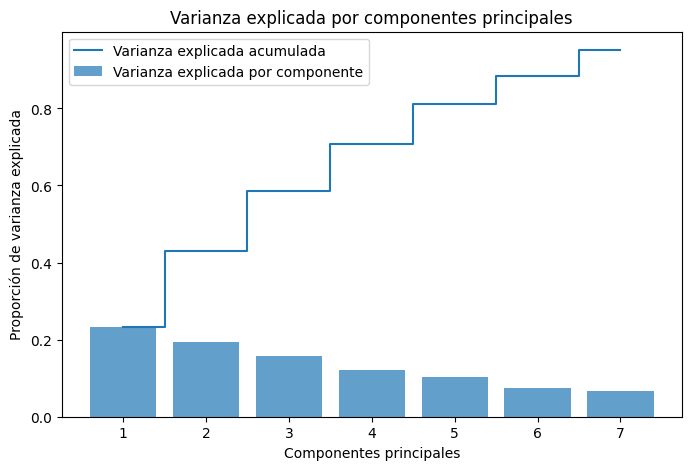

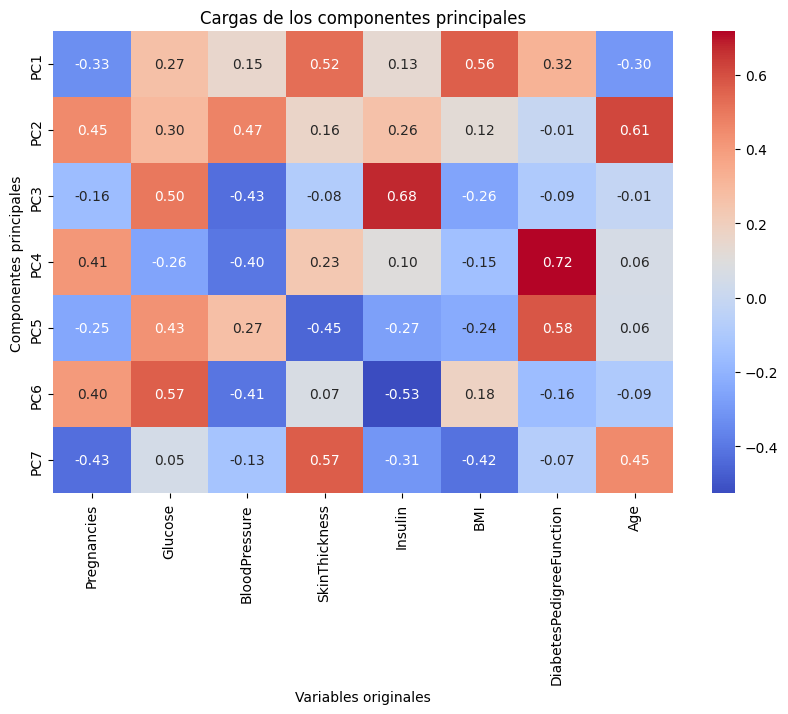

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, alpha=0.7, align='center', label='Varianza explicada por componente')
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Proporción de varianza explicada')
plt.title('Varianza explicada por componentes principales')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10, 6))
components_df = pd.DataFrame(pca.components_, columns=X_train_val.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])
sns.heatmap(components_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cargas de los componentes principales')
plt.xlabel('Variables originales')
plt.ylabel('Componentes principales')
plt.show()

<b> Gráfica de Varianza Explicada: </b>  
 - Los 7 primeros componentes explican el 95% de la varianza total.
 - Los primeros 3 componentes explican la mayor proporción (cerca del 60%), lo que indica que concentran gran parte de la información relevante.


<b> Mapa de Calor de Cargas de los Componentes Principales: </b>  

- PC1: Tiene altas cargas en SkinThickness, BMI y Glucose, lo que indica que estas variables son las más influyentes para este componente. Parece estar altamente influenciado por factores relacionados con la composición corporal y la glucosa en sangre.

- PC2: Está influenciado significativamente por Age, BloodPressure y Pregnancies. Puede estar capturando información sobre el historial reproductivo y la presión arterial en pacientes diabéticos.

- PC3: Esta influenciado por Insulin, Glucose y BloodPressure. Parece capturar patrones metabólicos relacionados con la resistencia a la insulina y el control de la glucosa

- PC4: Está influenciado principalmente por DiabetesPedigreeFunction, Pregnancies, BloodPressure. Es importante destacar que la función de pedigrí tiene una alta contribución, lo cual indica un patrón genético en los pacientes.

- PC5: Este componente parece complementar a PC3, enfocándose nuevamente en factores relacionados con la insulina y la glucosa, pero con menor influencia que PC3.

- PC6: Este componente parece captar una relación inversa entre el BMI y Glucose, junto con Pregnancies.

- PC7: Este componente parece capturar patrones relacionados con la edad, los niveles de insulina y una influencia inversa del número de embarazos.





- 2.3. Proyección de los Datos Restantes

En este punto, ya hemos construido el modelo PCA utilizando solo los datos de los pacientes diagnosticados con diabetes. Ahora, para poder comparar el rendimiento de nuestros clasificadores de manera consistente, necesitamos proyectar **todas** las muestras. Tanto los datos escalados de los pacientes con diabetes (restante 20%) como los de los pacientes sin diabetes, sobre este mismo modelo PCA.

##### **¿Por qué proyectar todos los datos sobre el mismo modelo PCA?**

1. **Consistencia de los descriptores**:
   - Al proyectar todos los datos sobre el mismo modelo PCA, obtenemos un conjunto de descriptores uniformes (los componentes principales) para todos los pacientes, independientemente de su diagnóstico. Esto es clave para que los clasificadores trabajen con las mismas variables de entrada.

2. **Reducción de la dimensionalidad**:
   - Utilizar los componentes principales como variables de entrada reduce el número de dimensiones, lo que facilita el entrenamiento de los modelos y reduce el riesgo de overfitting.

3. **Mejora de la generalización**:
   - Al usar descriptores PCA, que son las combinaciones lineales de las variables originales más informativas, se mejora la capacidad del modelo para generalizar a nuevos datos.

In [ ]:
# Separamos pacientes no diabéticos
non_diabetic_data = balanced_data[balanced_data['Outcome'] == 0]
X_non_diabetic = non_diabetic_data.drop('Outcome', axis=1)
y_non_diabetic = non_diabetic_data['Outcome']

# Normalizamos los datos restantes usando scaler
X_test_normalized = scaler.transform(X_test)
X_non_diabetic_normalized = scaler.transform(X_non_diabetic)

# Proyectamos sobre el modelo PCA
X_test_pca = pca.transform(X_test_normalized)
X_non_diabetic_pca = pca.transform(X_non_diabetic_normalized)
test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
test_pca_df['Outcome'] = y_test.values

non_diabetic_pca_df = pd.DataFrame(X_non_diabetic_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
non_diabetic_pca_df['Outcome'] = y_non_diabetic.values

# Unimos los datos proyectados (diabéticos y no diabéticos)
projected_data = pd.concat([test_pca_df, non_diabetic_pca_df], axis=0)

print("\n--- DataFrame proyectado ---")
print(projected_data.head())
print(f"Tamaño total del conjunto proyectado: {projected_data.shape}")


--- DataFrame proyectado ---
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.673771 -1.293924 -0.028037  1.032268 -0.314204  0.160295 -0.099849   
1  0.853098 -1.492245 -0.753666  1.604299 -0.695871  0.110670  0.705594   
2  1.094811  0.844172  1.717251 -0.086422 -0.641872  0.619786  0.039984   
3 -1.489531 -0.254703 -0.280840  0.020135 -0.181953 -0.453240  0.849489   
4 -2.152959 -1.624126  0.103582  0.567682 -0.690673  0.251760 -0.279991   

   Outcome  
0        1  
1        1  
2        1  
3        1  
4        1  
Tamaño total del conjunto proyectado: (600, 8)


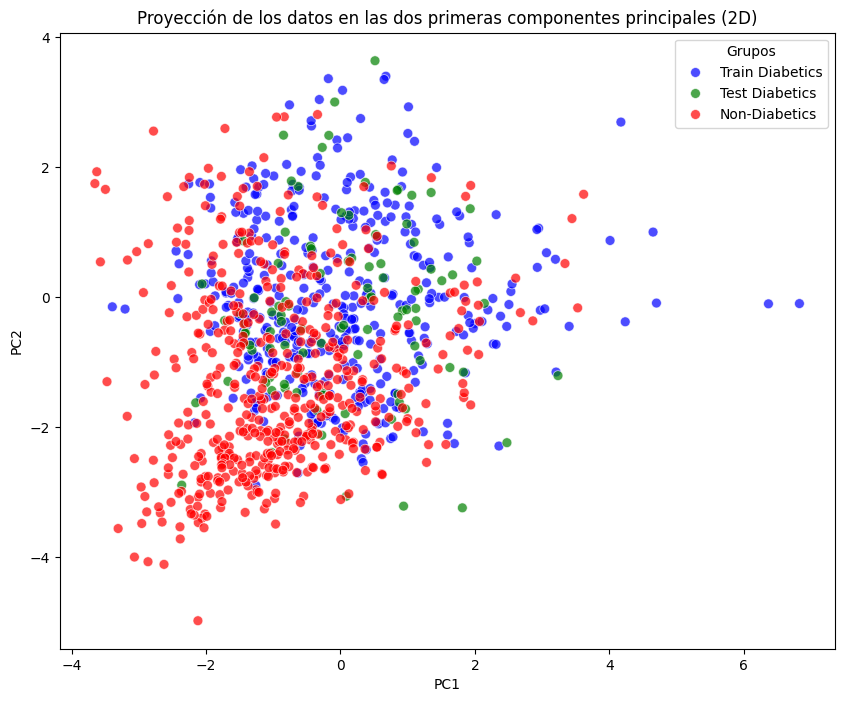

In [ ]:
train_labels = ['Train Diabetics'] * len(X_train_val_pca)
test_labels = ['Test Diabetics'] * len(X_test_pca)
non_diabetic_labels = ['Non-Diabetics'] * len(X_non_diabetic_pca)

data_2d = pd.DataFrame(
    np.vstack([X_train_val_pca[:, :2], X_test_pca[:, :2], X_non_diabetic_pca[:, :2]]),
    columns=['PC1', 'PC2']
)
data_2d['Group'] = train_labels + test_labels + non_diabetic_labels

# Gráfica en 2D
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Group',
    palette=['blue', 'green', 'red'],
    data=data_2d,
    alpha=0.7,
    s=50
)
plt.title("Proyección de los datos en las dos primeras componentes principales (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Grupos")
plt.show()

<b> Gráfica en 2D </b>

- Hay cierto solapamiento entre los grupos, lo cual es esperable debido a la naturaleza compleja de los datos y la reducción de dimensionalidad.

- Los pacientes no diabéticos (Non-Diabetics) tienden a ocupar un espacio distinto al de los pacientes diabéticos, aunque no hay una separación completamente clara.

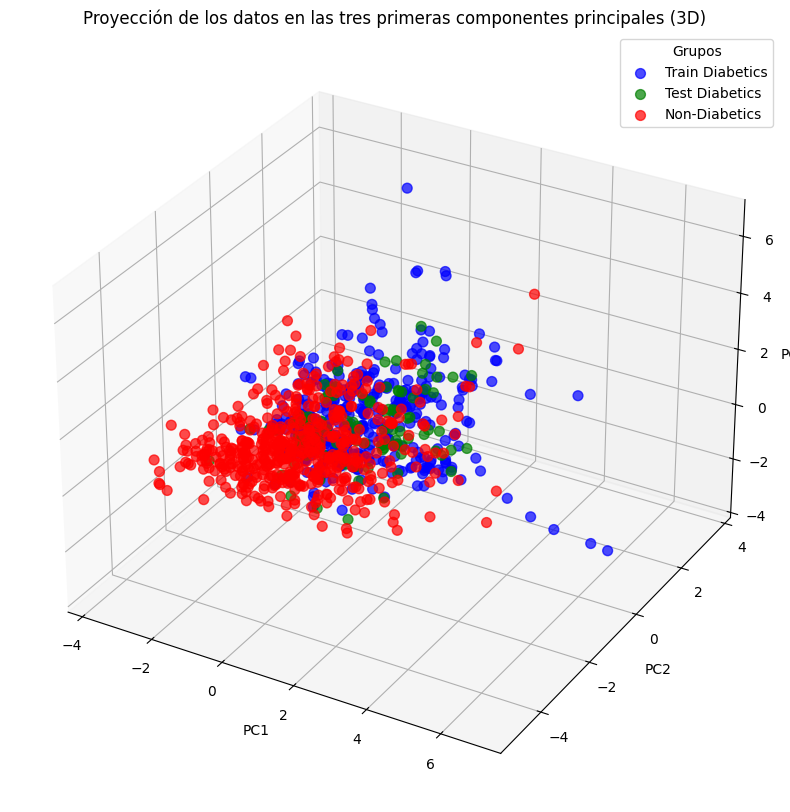

In [ ]:
data_3d = pd.DataFrame(
    np.vstack([X_train_val_pca[:, :3], X_test_pca[:, :3], X_non_diabetic_pca[:, :3]]),
    columns=['PC1', 'PC2', 'PC3']
)
data_3d['Group'] = train_labels + test_labels + non_diabetic_labels

# Gráfica en 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

colors = {'Train Diabetics': 'blue', 'Test Diabetics': 'green', 'Non-Diabetics': 'red'}

for group, color in colors.items():
    subset = data_3d[data_3d['Group'] == group]
    ax.scatter(
        subset['PC1'], subset['PC2'], subset['PC3'],
        label=group, c=color, alpha=0.7, s=50
    )

ax.set_title("Proyección de los datos en las tres primeras componentes principales (3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(title="Grupos")
plt.show()

<b> Gráfica en 3D </b>

- La tercera componente principal (PC3) mejora ligeramente la separación entre los grupos, pero sigue existiendo solapamiento, especialmente entre los datos de prueba diabéticos y los no diabéticos.


- 2.4. Creación del Conjunto de Entrenamiento para Clasificación

Al trabajar con modelos de PCA utilizando la librería `scikit-learn`, es importante entender que el objeto del PCA (`pca_final`) **no guarda automáticamente los componentes principales asociados a las muestras transformadas**. El PCA solo mantiene los componentes del modelo (es decir, las combinaciones lineales de las variables originales) y la información de la varianza explicada.

Para conservar los **valores de los componentes principales (scores)** asociados a cada muestra transformada para su uso futuro, hay que hacerlo **manualmente**, creando un DataFrame separado. Esto nos permitirá:

1. **Reutilizar los datos**: Podremos cargarlos directamente en el futuro sin tener que repetir el cálculo del PCA.
2. **Asegurar la consistencia**: Evitamos diferencias si el conjunto de datos original cambia o si se añaden nuevas muestras.
3. **Preparar los datos para el análisis**: Podemos combinar los scores con otras variables o utilizarlos directamente en modelos de clasificación.

In [ ]:
# Creamos los DataFrames para cada grupo
train_pca_df = pd.DataFrame(X_train_val_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
train_pca_df['Outcome'] = y_train_val.values

test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
test_pca_df['Outcome'] = y_test.values

non_diabetic_pca_df = pd.DataFrame(X_non_diabetic_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
non_diabetic_pca_df['Outcome'] = y_non_diabetic.values

# Combinamos todos los grupos en un solo conjunto de datos
classification_data = pd.concat([train_pca_df, test_pca_df, non_diabetic_pca_df], axis=0)

print("\n--- Primeras filas del conjunto de clasificación ---")
print(classification_data.head())

print("\n--- Distribución de clases en el conjunto de clasificación ---")
print(classification_data['Outcome'].value_counts())


--- Primeras filas del conjunto de clasificación ---
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.379447  0.303838 -1.072799 -0.036394 -0.528270 -0.719336  0.310708   
1  0.184577  1.089966 -0.179252 -1.130587  0.375826  0.976806 -0.388005   
2 -0.886954  0.666704 -1.224595  1.290994 -0.746233 -0.233266  0.395417   
3  1.095354  0.637888  0.434088  0.949765 -1.194407  0.447971 -0.638557   
4 -1.358981  0.393820 -0.888624 -0.110292 -0.743640 -0.849361 -0.640840   

   Outcome  
0        1  
1        1  
2        1  
3        1  
4        1  

--- Distribución de clases en el conjunto de clasificación ---
Outcome
1    500
0    500
Name: count, dtype: int64


### 3. Entrenamiento y Evaluación de Modelos Base 

Se formarán cuatro modelos diferentes:
- 1. Regresión Logística
- 2. Árbol de Decisión
- 3. Bosque Aleatorio (Random Forest)
- 4. SVM

y cada modelo será entrenado utilizando los dos grupos de:
- Las características originales
- Las características transformadas de PCA.

##### 3.1 Entrenamiento

3.1.1. Características originales


In [ ]:
X = balanced_data.drop('Outcome', axis=1)
y = balanced_data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42)
}

for name, model in models.items():
    print(f"\n--- {name} ---")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


--- Logistic Regression ---
Accuracy: 0.7350

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       100
           1       0.73      0.74      0.74       100

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.74      0.73      0.73       200


--- Decision Tree ---
Accuracy: 0.8150

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       100
           1       0.81      0.82      0.82       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200


--- Random Forest ---
Accuracy: 0.8150

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       100
           1       0.80      0.84      

<b> Logistic Regression: </b>
- Accuracy: 0.7350
- El modelo tiene un rendimiento balanceado en ambas clases (precision y recall alrededor de 0.73 para ambas).   


<b> Decision Tree: </b>
- Accuracy: 0.8150
- Mejor rendimiento que la regresión logística

<b> Random Forest: </b>
- Accuracy: 0.8150
- Similar al Árbol de Decisión, pero con ligeras mejoras en la clase 1 (diabéticos) gracias al ensamble.
- Ofrece un equilibrio sólido entre ambas clases.

<b> SVM : </b>
- Accuracy: 0.7300
- Desempeño similar a la regresión logística, con precisión y recall de 0.73.

3.1.2. Entradas de los componentes principales

Vamos a utilizar los componentes principales que has almacenado anteriormente de PCA. Pasos a seguir para las entradas de los componentes principales:

- 1. Combina los componentes principales diabéticos y no diabéticos: Combina los componentes principales de los datos diabéticos (entrenamiento y prueba) y no diabéticos en un único conjunto de datos para la clasificación.

- 2. Asigna las etiquetas de clase: Asigna 1 para muestras diabéticas y 0 para muestras no diabéticas.

- 3. Divide los datos combinados: Asegúrate de dividir el conjunto de datos combinado en conjuntos de entrenamiento (80%) y prueba si no lo has hecho ya. Esto evita la fuga de información de las pruebas al entrenamiento.

- 4. Entrenamiento y evaluación de modelos de clasificación: Utiliza el conjunto de datos para entrenar modelos que puedan separar eficazmente las clases diabéticas y no diabéticas.

In [ ]:
X_pca = classification_data.drop('Outcome', axis=1)
y_pca = classification_data['Outcome']

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_pca, test_size=0.2, random_state=42, stratify=y_pca
)

for name, model in models.items():
    print(f"\n--- {name} (PCA) ---")

    model.fit(X_train_pca, y_train_pca)

    y_pred_pca = model.predict(X_test_pca)

    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    print(f"Accuracy: {accuracy_pca:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_pca, y_pred_pca))


--- Logistic Regression (PCA) ---
Accuracy: 0.7150

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       100
           1       0.72      0.70      0.71       100

    accuracy                           0.71       200
   macro avg       0.72      0.71      0.71       200
weighted avg       0.72      0.71      0.71       200


--- Decision Tree (PCA) ---
Accuracy: 0.7600

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       100
           1       0.75      0.77      0.76       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200


--- Random Forest (PCA) ---
Accuracy: 0.7900

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       100
           1       0.

<b> Logistic Regression: </b>
- Accuracy: 0.7150
- Rendimiento ligeramente inferior al obtenido con las características originales (0.7350).
- Aunque PCA reduce la dimensionalidad, parece que la regresión logística no se beneficia significativamente de la transformación, lo cual puede indicar que las características originales ya capturaban patrones lineales relevantes.  


<b> Decision Tree: </b>
- Accuracy: 0.7600
- El rendimiento disminuye respecto a las características originales (0.8150).
- Los árboles de decisión son sensibles a la transformación PCA porque pierden información de las relaciones directas entre las características originales.

<b> Random Forest: </b>
- Accuracy: 0.7900
- El rendimiento disminuye ligeramente en comparación con las características originales (0.8150).
- Similar al Árbol de Decisión, Random Forest se basa en relaciones directas entre las características, lo que explica la pequeña pérdida de precisión.

<b> SVM : </b>
- Accuracy: 0.6950
- El rendimiento es similar al obtenido con las características originales (0.7300), aunque es ligeramente peor.

- 3.2. Entrenamiento de los modelos de clasificación con las variables originales


--- Logistic Regression (Variables Originales) ---
Exactitud: 0.7350
Sensibilidad: 0.7400
Especificidad: 0.7300
ROC-AUC: 0.8271


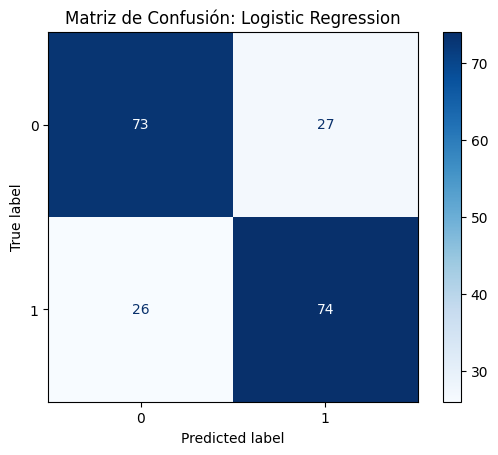

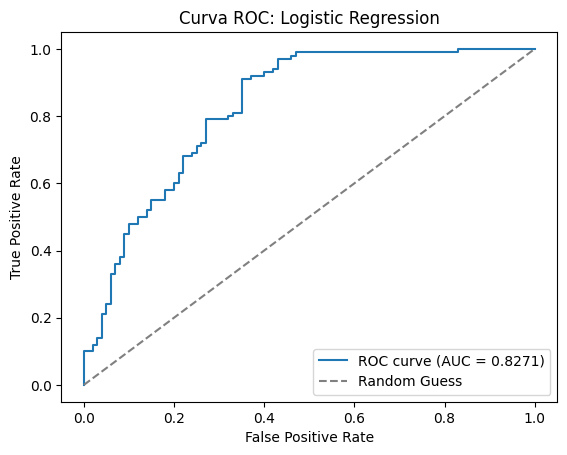


--- Decision Tree (Variables Originales) ---
Exactitud: 0.8150
Sensibilidad: 0.8200
Especificidad: 0.8100
ROC-AUC: 0.8150


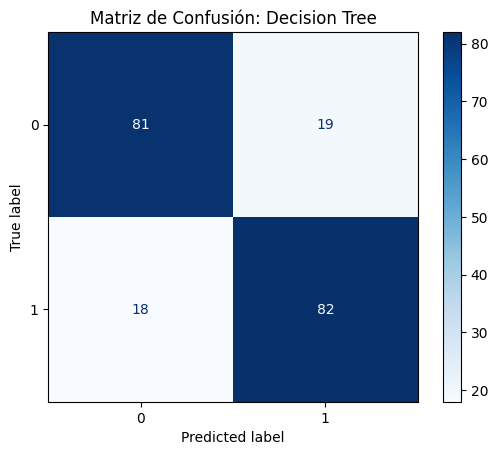

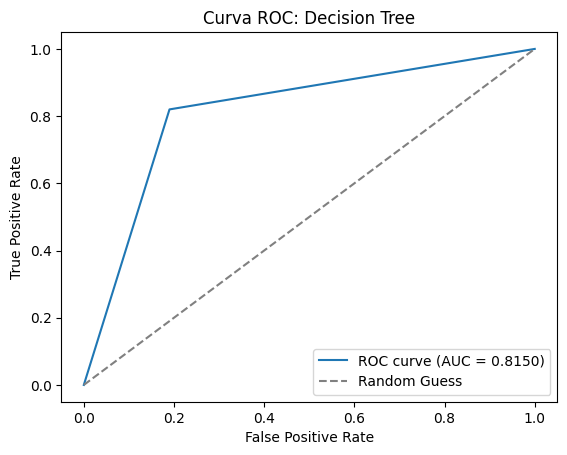


--- Random Forest (Variables Originales) ---
Exactitud: 0.8150
Sensibilidad: 0.8400
Especificidad: 0.7900
ROC-AUC: 0.9119


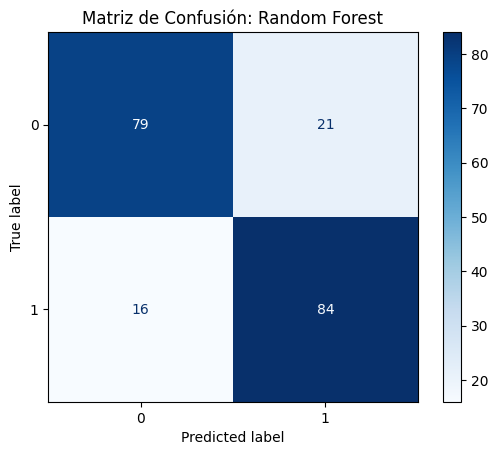

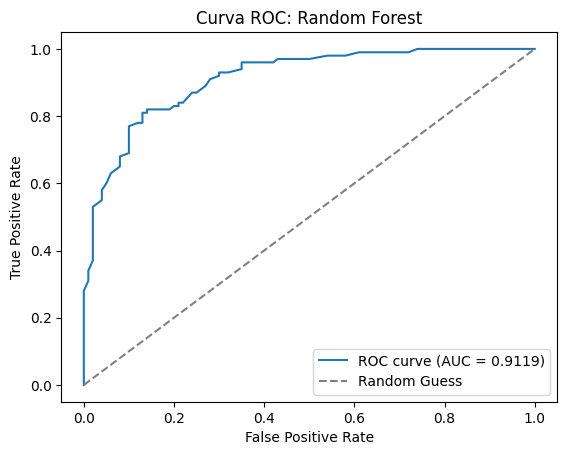


--- SVM (Variables Originales) ---
Exactitud: 0.7300
Sensibilidad: 0.7100
Especificidad: 0.7500


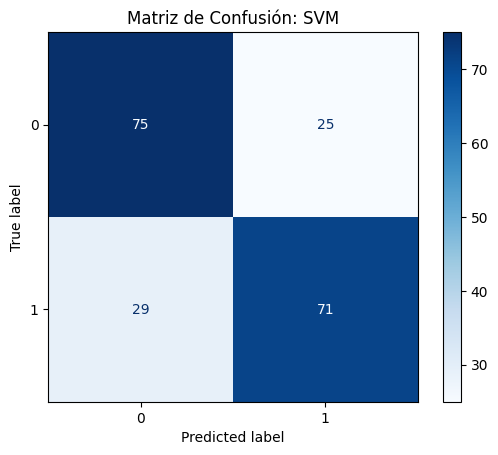

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Función para calcular sensibilidad y especificidad
def calculate_sensitivity_specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

for name, model in models.items():
    print(f"\n--- {name} (Variables Originales) ---")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    sensitivity, specificity = calculate_sensitivity_specificity(cm)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"Exactitud: {accuracy:.4f}")
    print(f"Sensibilidad: {sensitivity:.4f}")
    print(f"Especificidad: {specificity:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión: {name}")
    plt.show()

    if roc_auc is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC: {name}")
        plt.legend(loc="lower right")
        plt.show()

<b> Logistic Regression: </b>
- ROC-AUC: 0.8271
- La regresión logística tiene un buen balance entre sensibilidad y especificidad.
- Aunque no es el modelo más preciso, su curva ROC muestra una buena capacidad para separar las clases.

<b> Decision Tree: </b>
- ROC-AUC: 0.8150
- Buen rendimiento en general con sensibilidad y especificidad balanceadas.
- La precisión y el recall son altos, pero podría ser susceptible al overfitting si no se optimizan los hiperparámetros.

<b> Random Forest: </b>
- ROC-AUC: 0.9119
- El modelo con mejor rendimiento en general, con la ROC-AUC más alto (0.9119).
- El ensamble de árboles mejora la capacidad predictiva y reduce el riesgo de overfitting.


<b> SVM : </b>
- Similar a la regresión logística en términos de rendimiento.
- Aunque su sensibilidad es un poco más baja, tiene una buena especificidad.

- 3.3. Entrenamiento de los modelos de clasificación con las variables transformadas por los componentes principales (PCs)


--- Logistic Regression (Variables Transformadas por PCA) ---
Exactitud: 0.7150
Sensibilidad: 0.7000
Especificidad: 0.7300
ROC-AUC: 0.8149


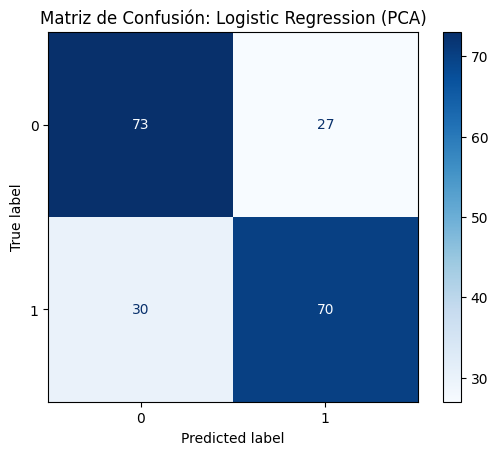

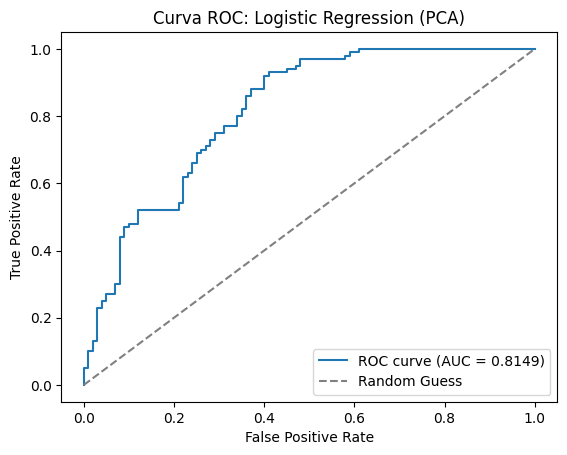


--- Decision Tree (Variables Transformadas por PCA) ---
Exactitud: 0.7600
Sensibilidad: 0.7700
Especificidad: 0.7500
ROC-AUC: 0.7600


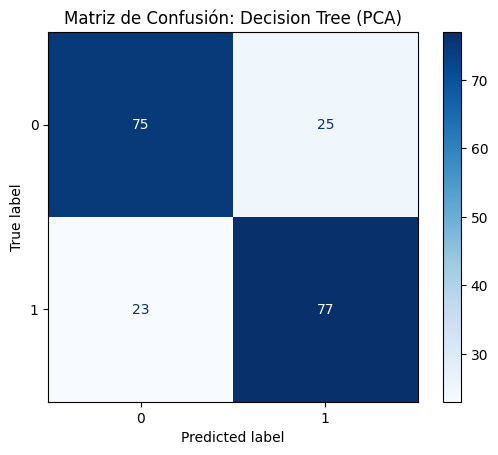

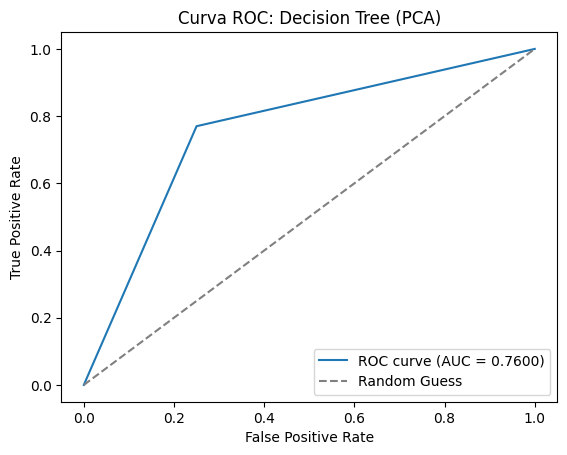


--- Random Forest (Variables Transformadas por PCA) ---
Exactitud: 0.7900
Sensibilidad: 0.8100
Especificidad: 0.7700
ROC-AUC: 0.8853


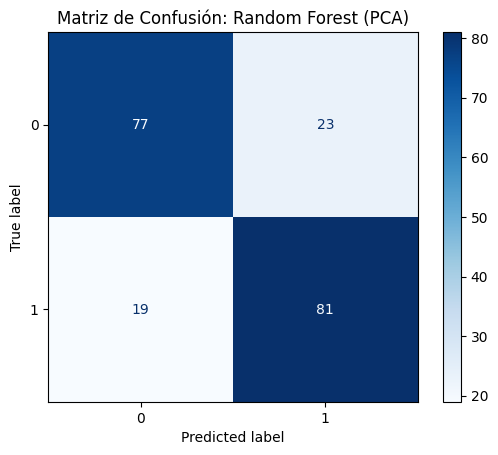

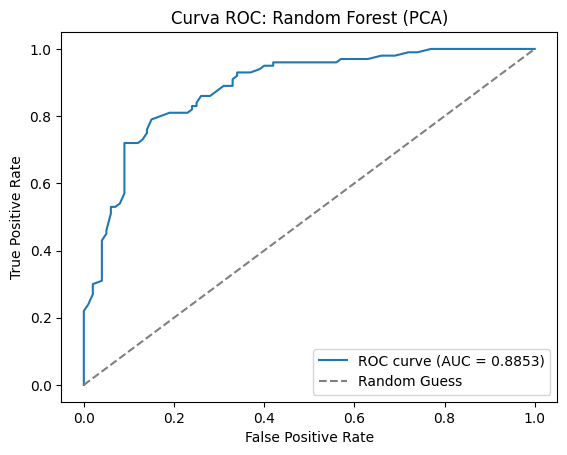


--- SVM (Variables Transformadas por PCA) ---
Exactitud: 0.6950
Sensibilidad: 0.6500
Especificidad: 0.7400


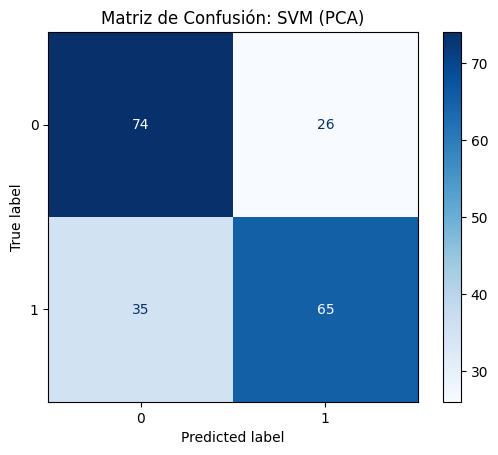

In [ ]:
for name, model in models.items():
    print(f"\n--- {name} (Variables Transformadas por PCA) ---")

    model.fit(X_train_pca, y_train_pca)

    y_pred_pca = model.predict(X_test_pca)
    y_pred_proba_pca = model.predict_proba(X_test_pca)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    cm_pca = confusion_matrix(y_test_pca, y_pred_pca)
    sensitivity_pca, specificity_pca = calculate_sensitivity_specificity(cm_pca)
    roc_auc_pca = roc_auc_score(y_test_pca, y_pred_proba_pca) if y_pred_proba_pca is not None else None

    print(f"Exactitud: {accuracy_pca:.4f}")
    print(f"Sensibilidad: {sensitivity_pca:.4f}")
    print(f"Especificidad: {specificity_pca:.4f}")
    if roc_auc_pca is not None:
        print(f"ROC-AUC: {roc_auc_pca:.4f}")

    disp_pca = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=[0, 1])
    disp_pca.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión: {name} (PCA)")
    plt.show()

    if roc_auc_pca is not None:
        fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_test_pca, y_pred_proba_pca)
        plt.figure()
        plt.plot(fpr_pca, tpr_pca, label=f"ROC curve (AUC = {roc_auc_pca:.4f})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC: {name} (PCA)")
        plt.legend(loc="lower right")
        plt.show()


<b> Logistic Regression: </b>
- ROC-AUC: 0.8149
- Tiene un rendimiento similar al obtenido con las características originales, con un ligero descenso en el ROC-AUC (de 0.8271 a 0.8149).
- El PCA no parece mejorar significativamente el rendimiento para este modelo lineal.

<b> Decision Tree: </b>
- ROC-AUC: 0.7600
- El rendimiento del Árbol de Decisión disminuye en comparación con las características originales (ROC-AUC bajó de 0.8150 a 0.7600).
- Este modelo no parece beneficiarse del PCA, ya que pierde relaciones directas entre variables originales.

<b> Random Forest: </b>
- ROC-AUC: 0.8853
- Aunque el rendimiento es bueno, el ROC-AUC disminuyó en comparación con las características originales (de 0.9119 a 0.8853).
- Similar al Árbol de Decisión, Random Forest no se beneficia del PCA, pero sigue siendo el mejor modelo en general.


<b> SVM : </b>
- El rendimiento es similar al obtenido con las características originales.
- Esto sugiere que el PCA no tiene un impacto significativo en este modelo, al menos con el kernel lineal utilizado.

- 3.4 Análisis de resultados

- En general, las variables originales ofrecen un mejor rendimiento que los componentes principales (PCA) en este conjunto de datos. Esto se debe a que las características originales ya capturaban suficiente información relevante para la clasificación.

- Los modelos lineales (Regresión Logística y SVM) tienen un rendimiento similar con y sin PCA, pero las variables originales son marginalmente mejores.

- En los modelos no lineales (Árbol de Decisión y Random Forest) el PCA perjudica su desempeño al eliminar relaciones directas entre variables.

- Tanto con las variables originales como con PCA, Random Forest es el modelo más robusto, con el mejor equilibrio entre sensibilidad, especificidad y ROC-AUC.

### **4. Técnicas Avanzadas de Ensemble**



**1. Clase `CascadingClassifier`**

###### **Propósito:**
- Implementaremos una técnica personalizada de aprendizaje en ensamblado donde las predicciones de un primer modelo (`base_model1`) se añaden como características adicionales a los datos de entrada para un segundo modelo (`base_model2`).

###### **Componentes clave:**
- **Método `__init__`:**
  - Inicializa el clasificador con dos modelos base.
- **Método `fit`:**
  - Entrena el `base_model1` con las características de entrada (`X`) y las etiquetas (`y`).
  - Genera las predicciones del `base_model1` y las añade como una nueva columna a las características de entrada.
  - Entrena el `base_model2` con este conjunto de datos aumentado.
- **Método `predict`:**
  - Utiliza el `base_model1` entrenado para predecir las etiquetas de los datos de entrada.
  - Aumenta las características de entrada con estas predicciones y las pasa al `base_model2` para obtener las predicciones finales.
- **Método `predict_proba`:**
  - Similar a `predict`, pero devuelve las probabilidades de clase para los datos de entrada.

###### **Librerías y técnicas clave:**
- **`np.hstack`:** Combina arrays por columnas para añadir las predicciones como características.
- **`BaseEstimator` y `ClassifierMixin`:** Garantizan la compatibilidad con los pipelines y métodos de evaluación de Scikit-learn.

---

**2. Función `evaluate_ensemble`**

###### **Propósito:**
- Evaluaremos el rendimiento de los modelos ensemble utilizando métricas como el accuracy, la sensibilidad, la especificidad y el ROC-AUC. También genera una matriz de confusión y la curva ROC.



In [ ]:
class CascadingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model1, base_model2):
        self.base_model1 = base_model1
        self.base_model2 = base_model2

    def fit(self, X, y):
        self.base_model1.fit(X, y)
        pred1 = self.base_model1.predict(X).reshape(-1, 1)
        X_augmented = np.hstack([X, pred1])
        self.base_model2.fit(X_augmented, y)
        return self

    def predict(self, X):
        pred1 = self.base_model1.predict(X).reshape(-1, 1)
        X_augmented = np.hstack([X, pred1])
        return self.base_model2.predict(X_augmented)

    def predict_proba(self, X):
        pred1 = self.base_model1.predict(X).reshape(-1, 1)
        X_augmented = np.hstack([X, pred1])
        return self.base_model2.predict_proba(X_augmented)

In [ ]:
def evaluate_ensemble(model, X_train, y_train, X_test, y_test, name="Ensemble Model"):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n--- {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensibilidad: {sensitivity:.4f}")
    print(f"Especificidad: {specificity:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión: {name}")
    plt.show()

    if roc_auc is not None:
        RocCurveDisplay.from_predictions(y_test, y_pred_proba)
        plt.title(f"Curva ROC: {name}")
        plt.show()


--- Bagging ---
Accuracy: 0.8250
Sensibilidad: 0.8500
Especificidad: 0.8000
ROC-AUC: 0.9049


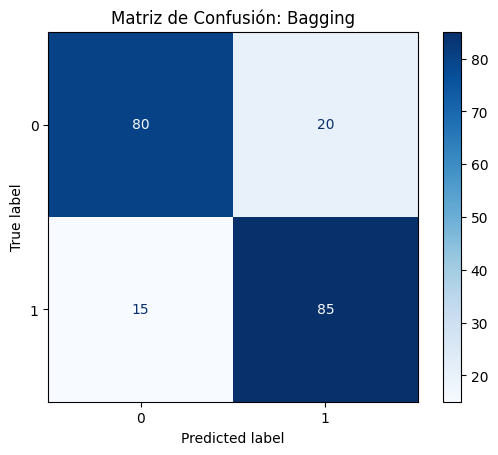

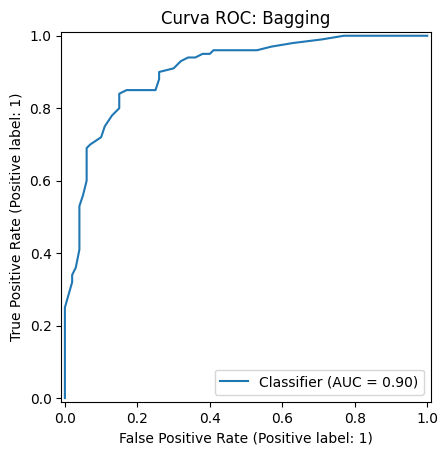


--- Boosting ---
Accuracy: 0.8200
Sensibilidad: 0.8800
Especificidad: 0.7600
ROC-AUC: 0.8770


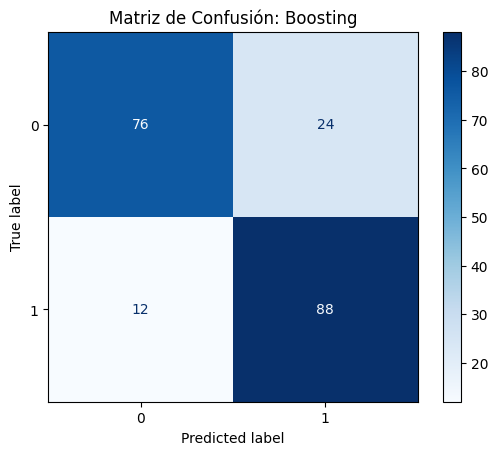

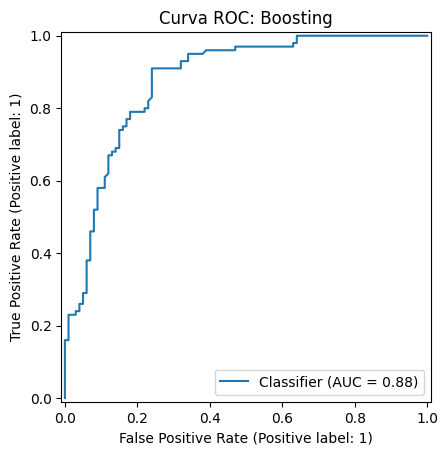


--- Cascading ---
Accuracy: 0.8150
Sensibilidad: 0.8400
Especificidad: 0.7900
ROC-AUC: 0.8521


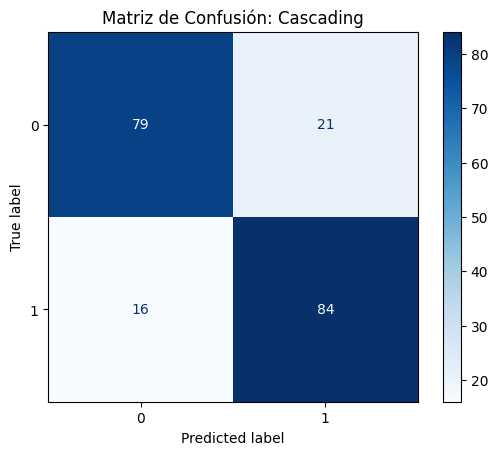

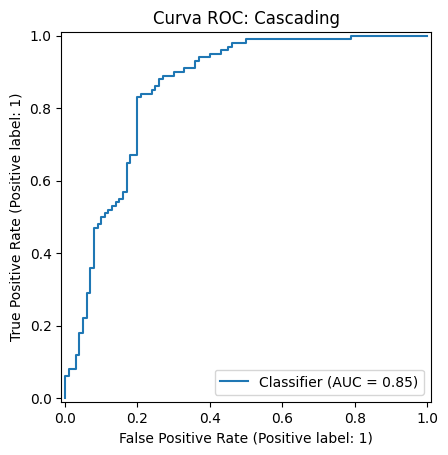

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Bagging
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
evaluate_ensemble(bagging_model, X_train, y_train, X_test, y_test, name="Bagging")

# Boosting
boosting_model = GradientBoostingClassifier(n_estimators=50, random_state=42)
evaluate_ensemble(boosting_model, X_train, y_train, X_test, y_test, name="Boosting")

# Cascading
cascading_model = CascadingClassifier(
    base_model1=RandomForestClassifier(random_state=42),
    base_model2=LogisticRegression(max_iter=1000)
)
evaluate_ensemble(cascading_model, X_train, y_train, X_test, y_test, name="Cascading")


--- Bagging PCA ---
Accuracy: 0.8050
Sensibilidad: 0.8100
Especificidad: 0.8000
ROC-AUC: 0.8840


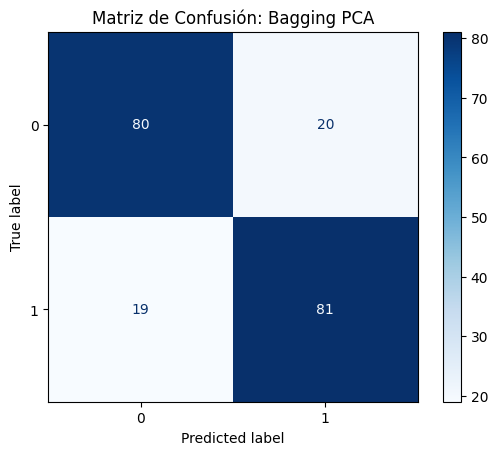

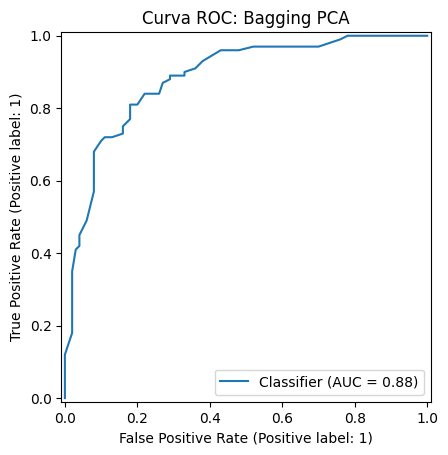


--- Boosting PCA ---
Accuracy: 0.7250
Sensibilidad: 0.7400
Especificidad: 0.7100
ROC-AUC: 0.8401


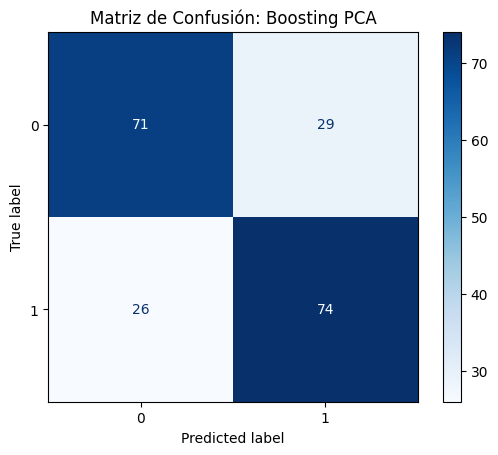

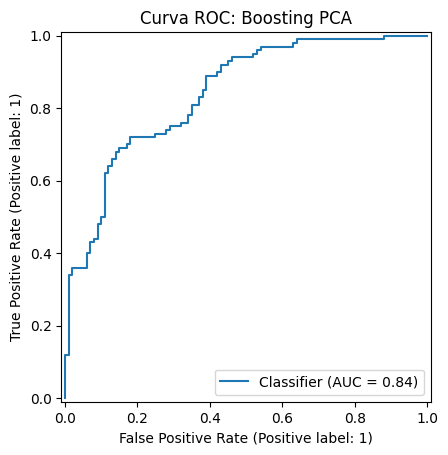


--- Cascading PCA ---
Accuracy: 0.7900
Sensibilidad: 0.8100
Especificidad: 0.7700
ROC-AUC: 0.8335


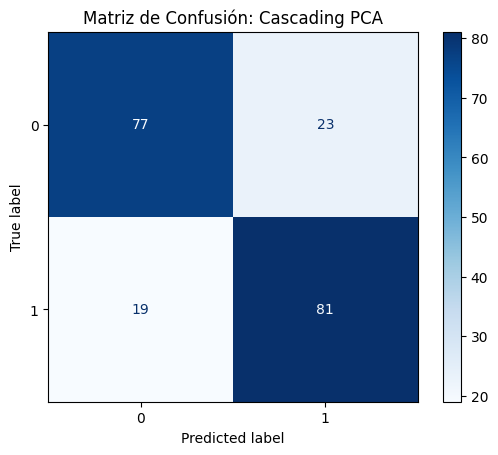

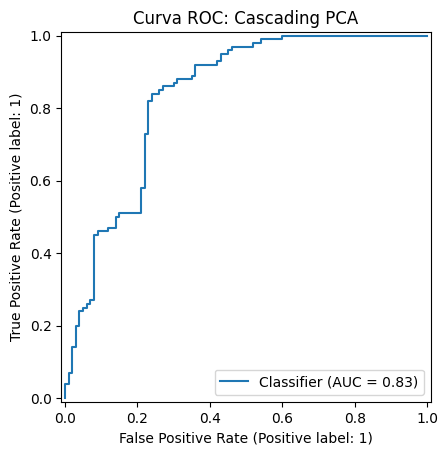

In [ ]:
# Bagging
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
evaluate_ensemble(bagging_model, X_train_pca , y_train, X_test_pca , y_test, name="Bagging PCA")

# Boosting
boosting_model = GradientBoostingClassifier(n_estimators=50, random_state=42)
evaluate_ensemble(boosting_model, X_train_pca , y_train, X_test_pca , y_test, name="Boosting PCA")

# Cascading
cascading_model = CascadingClassifier(
    base_model1=RandomForestClassifier(random_state=42),
    base_model2=LogisticRegression(max_iter=1000)
)
evaluate_ensemble(cascading_model, X_train_pca , y_train, X_test_pca , y_test, name="Cascading PCA")

<B> Bagging </b>
- <b>Con Variables Originales:</b>
  - Obtiene el mejor rendimiento general con una exactitud del 82.5% y un ROC-AUC de 0.9049.
  -Tiene un equilibrio notable entre sensibilidad (85%) y especificidad (80%).

- <b>Con PCA:</b>
  - El rendimiento disminuye ligeramente (ROC-AUC baja a 0.8840), pero la especificidad y sensibilidad se mantienen equilibradas.
  - Esto indica que Bagging maneja bien las variables transformadas, pero se beneficia más de las relaciones directas en las variables originales.

<B> Boosting </b>
- <b>Con Variables Originales:</b>
  - Tiene una muy buena sensibilidad (88%), lo que lo convierte en el mejor modelo para identificar correctamente a los pacientes diabéticos.
  - Sin embargo, la especificidad es más baja (76%), lo que implica un mayor número de falsos positivos.
  - ROC-AUC: 0.8770, mostrando una buena capacidad discriminativa.

- <b>Con PCA:</b>
  - El rendimiento disminuye significativamente (exactitud: 72.5%, ROC-AUC: 0.8401).
  - Boosting depende mucho de las relaciones entre variables originales, y el PCA afecta negativamente su capacidad para capturar patrones útiles.

<B> Cascading </b>
- <b>Con Variables Originales:</b>
  - Rendimiento sólido, con exactitud del 81.5% y ROC-AUC de 0.8521.

- <b>Con PCA:</b>
  - Aunque el rendimiento disminuye ligeramente, sigue siendo bueno (exactitud: 79%, ROC-AUC: 0.8335).


Bagging con variables originales es el mejor método con exactitud del 82.5% y un ROC-AUC de 0.9049. Combina buena sensibilidad y especificidad, siendo robusto frente a desequilibrios.

El PCA puede ser útil en datos de alta dimensionalidad o cuando las variables originales tienen ruido significativo. Sin embargo, en este caso, las variables originales ya contenían suficiente información discriminativa.

### **5. Convolutional Neural Network para Datos Tabulares**

5.1 ¿Qué es una CNN?
**CNN** significa **Red Neuronal Convolucional** (en inglés, **Convolutional Neural Network**). Es un tipo de red neuronal profunda utilizada principalmente en tareas de visión por computador, aunque también se aplica en otros campos como el procesamiento del lenguaje natural y las series temporales.

Una CNN es especialmente efectiva para analizar **imágenes** y **datos espaciales** porque puede identificar automáticamente **patrones, bordes y características** en diferentes niveles de abstracción. Es decir, aprende a detectar características simples como líneas o colores en las primeras capas y características más complejas (caras, objetos, etc.) en capas más profundas.

**Componentes de una CNN:**
1. **Capa Convolucional (Convolutional Layer):**
 Aplica filtros a la imagen de entrada para extraer características como bordes, texturas o formas.

2. **Función de Activación (Activation Function):**
 Introduce no linealidad en el modelo. La más utilizada es **ReLU (Rectified Linear Unit)**, que elimina valores negativos.

3. **Capa de Pooling (Pooling Layer):**
 Reduce la dimensionalidad de las características extraídas, disminuyendo el tiempo de cálculo y evitando el sobreajuste. **max-pooling** es el más común, ya que selecciona el valor máximo dentro de una región.

4. **Capas Densas (Fully Connected Layers):**
 Conectan todas las neuronas previas y generan la salida final, como la clasificación de una imagen (por ejemplo, perro vs. gato).

---

### **Ejemplo de Aplicación:**
- **Clasificación de Imágenes:** Identificación de objetos en imágenes (reconocimiento facial, vehículos, etc.).
- **Detección de Anomalías:** Reconocimiento de patrones anómalos en imágenes médicas o de seguridad.
- **Reconocimiento de Texto:** Detección de caracteres o texto manuscrito.


---

5.2. Adaptación de los datos para utilizar una CNN

En este apartado, transformaremos los datos tabulares en una forma que pueda ser procesada por un modelo personalizado, como un Custom CNN. Esto implica representar los datos tabulares como "imágenes" (matrices en 2D o 3D) para cumplir con los requisitos de entrada del modelo.

---

5.2.1. ¿Por qué es necesario transformar los datos tabulares?
Los modelos convolucionales están diseñados para trabajar con datos en forma de matrices (altura, anchura, canales), habitualmente para procesar imágenes. En el caso de nuestros datos:
- Los datos originales tienen **8 características** (por ejemplo, `Glucose`, `BMI`, etc.).
- Los datos PCA tienen **7 componentes principales**, que son combinaciones lineales de las características originales.

Dado que estas características son unidimensionales, es necesario transformarlas para que el modelo pueda procesarlas como "imágenes artificiales".

---

5.2.2. ¿Cómo se transforma una matriz unidimensional en una "imagen"?

Para convertir los datos tabulares en "imágenes", debemos:

1. **Decidir la forma de entrada (`input_shape`):**
 - Los datos originales con **8 características** se pueden reorganizar en una matriz de **\(2 x 4 x 1\)** (2 filas, 4 columnas y 1 canal).
 - Los datos PCA con **7 componentes principales** se pueden reorganizar en una matriz de **\(7 x 1 x 1\)**.

2. **Validar la forma de los datos:**
 - El número total de características debe coincidir con el producto \( altura x anchura x canales \).
 - Por ejemplo, para los datos originales, \(2 x 4 x 1 = 8 \), que corresponde al número de características.

3. **Aplicar la transformación:**
 - Reorganizamos cada muestra para que tenga la forma adecuada mediante un código personalizado.

---

- 5.3 Transformación de los datos

1. **Datos originales (8 características):** Los datos originales con 8 características se pueden reorganizar en una matriz de (2 x 4 x 1) (2 filas, 4 columnas y 1 canal).

2. **Datos PCA (7 componentes principales):**  
Los datos PCA con 7 componentes principales se pueden reorganizar en una matriz de (7 x 1 x 1).

In [ ]:
def transform_to_images(data, input_shape):
    n_samples, n_features = data.shape
    assert np.prod(input_shape) == n_features, (
        "El producto de la forma de entrada debe coincidir con el número de características."
    )
    return data.values.reshape((n_samples, *input_shape))

# Datos originales
input_shape_original = (2, 4, 1)
X_train_images = transform_to_images(X_train, input_shape_original)
X_test_images = transform_to_images(X_test, input_shape_original)

# Datos PCA
input_shape_pca = (7, 1, 1)
X_train_pca_images = transform_to_images(X_train_pca, input_shape_pca)
X_test_pca_images = transform_to_images(X_test_pca, input_shape_pca)

print(f"Forma de X_train_images (original): {X_train_images.shape}")
print(f"Forma de X_train_pca_images (PCA): {X_train_pca_images.shape}")

Forma de X_train_images (original): (800, 2, 4, 1)
Forma de X_train_pca_images (PCA): (800, 7, 1, 1)


In [ ]:
def create_cnn(input_shape):
    model = Sequential([
        Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_pca(input_shape):
    model = Sequential([
        # Capa convolucional inicial adaptada a (7, 1, 1)
        Conv2D(16, kernel_size=(2, 1), activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_original = create_cnn((2, 4, 1))
history_original = cnn_original.fit(
    X_train_images, y_train,
    validation_data=(X_test_images, y_test),
    epochs=20, batch_size=32, verbose=1
)

cnn_pca = create_cnn_pca((7, 1, 1))
history_pca = cnn_pca.fit(
    X_train_pca_images, y_train,
    validation_data=(X_test_pca_images, y_test),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5476 - loss: 9.7910 - val_accuracy: 0.5000 - val_loss: 3.1241
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4933 - loss: 5.3392 - val_accuracy: 0.5550 - val_loss: 0.8067
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5292 - loss: 3.0217 - val_accuracy: 0.5950 - val_loss: 0.7842
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5377 - loss: 1.7779 - val_accuracy: 0.5850 - val_loss: 0.7308
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5656 - loss: 1.1666 - val_accuracy: 0.6100 - val_loss: 0.6898
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5737 - loss: 0.8570 - val_accuracy: 0.5850 - val_loss: 0.6673
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5634 - loss: 0.8063 - val_accuracy: 0.6750 - val_loss: 0.6569
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6356 - loss: 0.6512 - val_accuracy: 0.6600 - val_loss: 0.6521
Ep

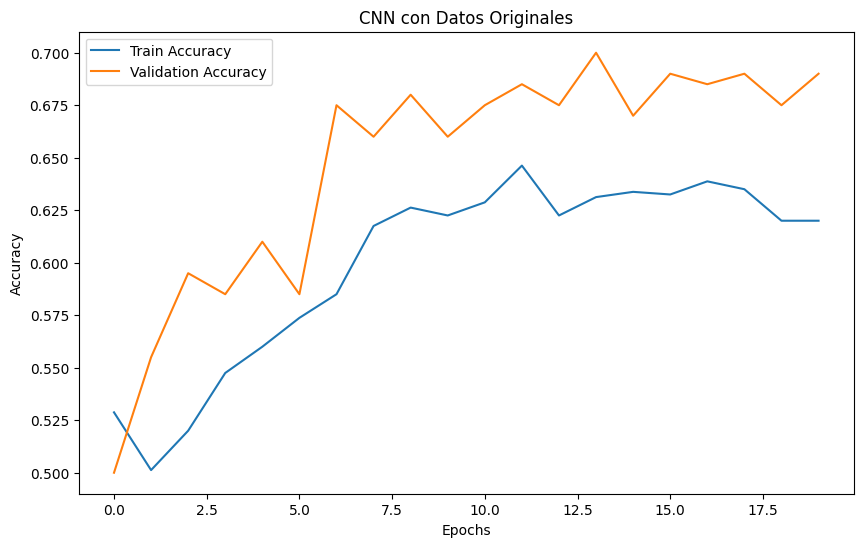

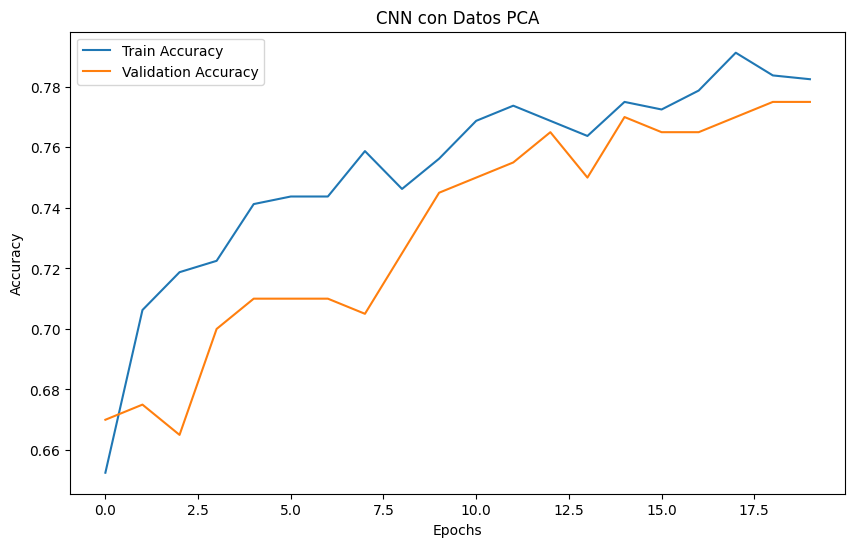

In [ ]:
def plot_learning_curve(history, title="Learning Curve"):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_learning_curve(history_original, title="CNN con Datos Originales")

plot_learning_curve(history_pca, title="CNN con Datos PCA")

In [ ]:
test_loss_original, test_accuracy_original = cnn_original.evaluate(X_test_images, y_test, verbose=0)
print(f"Datos Originales - Exactitud en Test: {test_accuracy_original:.4f}")

test_loss_pca, test_accuracy_pca = cnn_pca.evaluate(X_test_pca_images, y_test, verbose=0)
print(f"Datos PCA - Exactitud en Test: {test_accuracy_pca:.4f}")

Datos Originales - Exactitud en Test: 0.6900
Datos PCA - Exactitud en Test: 0.7750


Los datos transformados por PCA generan un mejor rendimiento en la CNN, con una exactitud en test del 77.5%.

- **5.4. Conversión de datos a float32**

**¿Por qué es necesario convertir los datos a `float32`?**

En el ámbito del aprendizaje automático y el procesamiento de datos, es habitual que sea necesario convertir los datos al formato `float32`. Pros:

---

**Eficiencia de memoria**
- **Reducción del uso de memoria**: El formato `float32` utiliza 4 bytes de memoria, mientras que `float64` (el formato predeterminado en muchas librerías como NumPy o Pandas) utiliza 8 bytes. En conjuntos de datos grandes, esta diferencia puede reducir significativamente el consumo de memoria.
- **Adaptabilidad para GPUs**: Las GPUs suelen trabajar con `float32` de manera nativa. Utilizar este formato evita un uso innecesario de memoria y mejora la eficiencia computacional.

---

**Optimización del rendimiento**
- **Cálculos más rápidos**: Los cálculos con `float32` son más rápidos que con `float64`, especialmente en GPUs, ya que muchas herramientas de aprendizaje profundo (como TensorFlow o PyTorch) están optimizadas para `float32`.
- **Tiempo de transferencia reducido**: Transferir datos entre CPU y GPU es más rápido cuando los datos están en formato `float32`, gracias al menor volumen de datos.

---

**Evitar problemas de compatibilidad**
- **Requisitos de las herramientas**: Muchas herramientas de aprendizaje automático, como TensorFlow o Keras, esperan que los datos de entrada estén en formato `float32`. Si se utiliza `float64`, se pueden generar advertencias o errores que obligarán a hacer la conversión posteriormente.
- **Modelos preentrenados**: La mayoría de los modelos preentrenados y operaciones en aprendizaje profundo están diseñados para trabajar con `float32`. Esto asegura la compatibilidad y evita desajustes entre tipos de datos.

---

**Impacto mínimo en la precisión**
- **Precisión suficiente**: Para la mayoría de tareas de aprendizaje automático, la precisión que ofrece `float32` es más que suficiente. Aunque `float64` proporciona una precisión más alta, esta normalmente no es necesaria en aplicaciones prácticas.
- **Control de errores**: El formato `float32` ayuda a mitigar problemas como desbordamientos o subdesbordamientos de valores, que pueden ser más probables con `float64`.

---

**Buenas prácticas en la industria**
- **Consistencia**: Mantener el mismo tipo de datos en toda la pipeline (entrada, pesos del modelo, salidas) evita comportamientos inesperados o incompatibilidades durante los cálculos.
- **Estándar**: La mayoría de librerías y herramientas de aprendizaje automático utilizan `float32` como formato predeterminado. Esto hace que este formato sea un estándar para garantizar la compatibilidad.

---

**¿Cuándo no es necesario convertir a `float32`?**
- **Requisitos de alta precisión**: Si la aplicación requiere cálculos muy precisos (por ejemplo, simulaciones científicas), podría ser más adecuado utilizar `float64`.
- **Conjuntos de datos pequeños**: Si el conjunto de datos es pequeño y el consumo de memoria no es un problema, la conversión puede no ser imprescindible.

---

Por tanto, a la hora de preparar los datos para una pipeline de aprendizaje automático, **debes convertirlos a `float32` para mejorar el rendimiento, reducir el consumo de memoria y garantizar la compatibilidad con las herramientas modernas.** Esto es especialmente importante si estás trabajando con conjuntos de datos grandes o entrenando modelos en GPUs.

In [ ]:
# Convertir datos originales a float32
X_train_images = X_train_images.astype('float32')
X_test_images = X_test_images.astype('float32')

# Convertir datos PCA a float32
X_train_pca_images = X_train_pca_images.astype('float32')
X_test_pca_images = X_test_pca_images.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

print(f"Tipo de datos (X_train_images): {X_train_images.dtype}")
print(f"Tipo de datos (X_test_images): {X_test_images.dtype}")
print(f"Tipo de datos (X_train_pca_images): {X_train_pca_images.dtype}")
print(f"Tipo de datos (X_test_pca_images): {X_test_pca_images.dtype}")
print(f"Tipo de datos (y_train): {y_train.dtype}")
print(f"Tipo de datos (y_test): {y_test.dtype}")

Tipo de datos (X_train_images): float32
Tipo de datos (X_test_images): float32
Tipo de datos (X_train_pca_images): float32
Tipo de datos (X_test_pca_images): float32
Tipo de datos (y_train): float32
Tipo de datos (y_test): float32


- Errores comunes y cómo evitarlos  
1. **Forma de entrada incorrecta:**  
   - Si el número de características no coincide con el producto de la forma de entrada especificada, aparecerá un error.  
   - **Solución:** Comprueba que el número de características \(n\) = \(altura x anchura x canales\).  

2. **Transformación repetida:**  
   - Transformar los datos repetidamente puede generar errores.  
   - **Solución:** Utiliza solo los datos transformados (por ejemplo, `X_train_original_reshaped`) en entrenamientos posteriores.  

3. **Diferencias en las dimensiones entre datos de entrenamiento y test:**  
   - Si los datos de entrenamiento y test tienen dimensiones diferentes, ResNet50 no podrá procesarlos.  
   - **Solución:** Asegúrate de que la transformación se aplica de manera consistente a todos los datos.  

In [ ]:
# Datos originales
print("Forma de los datos originales:")
print(f"X_train_images: {X_train_images.shape}")
print(f"X_test_images: {X_test_images.shape}")

# Datos PCA
print("\nForma de los datos PCA:")
print(f"X_train_pca_images: {X_train_pca_images.shape}")
print(f"X_test_pca_images: {X_test_pca_images.shape}")

Forma de los datos originales:
X_train_images: (800, 2, 4, 1)
X_test_images: (200, 2, 4, 1)

Forma de los datos PCA:
X_train_pca_images: (800, 7, 1, 1)
X_test_pca_images: (200, 7, 1, 1)


Los datos tienen la forma correcta

- 5.5. Entrenamiento del modelo utilizando los datos preprocesados y compara el rendimiento con los métodos de ensemble.

Args:
- X_train: Datos de entrenamiento (ya transformados).
- X_test: Datos de prueba (ya transformados).
- y_train: Etiquetas de entrenamiento.
- y_test: Etiquetas de prueba.
- input_shape: Forma de los datos de entrada.
- dataset_type: Cadena que indica si el conjunto de datos es "original" o "pca".
- Imprime: métricas de evaluación y dibuja la curva ROC.

In [ ]:
def train_and_evaluate_cnn(X_train, X_test, y_train, y_test, input_shape, dataset_type=""):
    if input_shape == (7, 1, 1):
        kernel_size = (2, 1)
    else:
        kernel_size = (2, 2)

    model = Sequential([
        Input(shape=input_shape),
        Conv2D(16, kernel_size=kernel_size, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20, batch_size=32, verbose=1
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n--- CNN ({dataset_type}) ---")
    print(f"Exactitud en Test: {test_accuracy:.4f}")

    y_pred = model.predict(X_test).ravel()
    y_pred_binary = (y_pred > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_binary))

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC: CNN ({dataset_type})')
    plt.legend(loc='lower right')
    plt.show()

    return test_accuracy, roc_auc


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4866 - loss: 4.9292 - val_accuracy: 0.6200 - val_loss: 0.7926
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5179 - loss: 2.3945 - val_accuracy: 0.6900 - val_loss: 0.7162
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5772 - loss: 1.6712 - val_accuracy: 0.7400 - val_loss: 0.6469
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6073 - loss: 1.1548 - val_accuracy: 0.6700 - val_loss: 0.6265
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5946 - loss: 0.9427 - val_accuracy: 0.6950 - val_loss: 0.6007
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6352 - loss: 0.6952 - val_accuracy: 0.6700 - val_loss: 0.6229
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5961 - loss: 0.7745 - val_accuracy: 0.6800 - val_loss: 0.6592
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6744 - loss: 0.6425 - val_accuracy: 0.6900 - val_los

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.72      0.77       100
         1.0       0.75      0.84      0.79       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200


Confusion Matrix:
[[72 28]
 [16 84]]


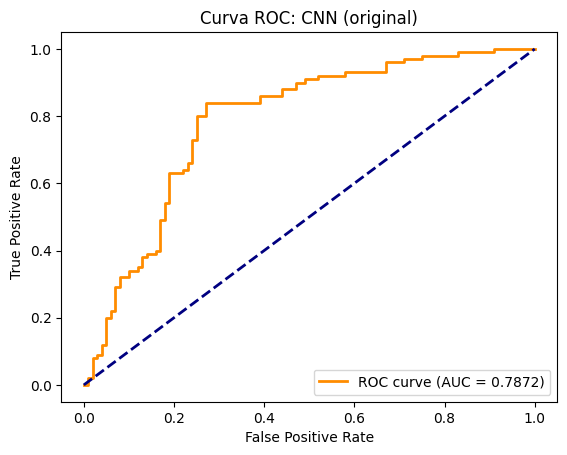

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5809 - loss: 0.6647 - val_accuracy: 0.7050 - val_loss: 0.5890
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6833 - loss: 0.5665 - val_accuracy: 0.7150 - val_loss: 0.5716
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7558 - loss: 0.5261 - val_accuracy: 0.7100 - val_loss: 0.5658
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7351 - loss: 0.5316 - val_accuracy: 0.7100 - val_loss: 0.5612
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7534 - loss: 0.4942 - val_accuracy: 0.7000 - val_loss: 0.5592
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7357 - loss: 0.5120 - val_accuracy: 0.7200 - val_loss: 0.5499
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7525 - loss: 0.4835 - val_accuracy: 0.7150 - val_loss: 0.5464
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7347 - loss: 0.5161 - val_accuracy: 0.7200 - val_loss

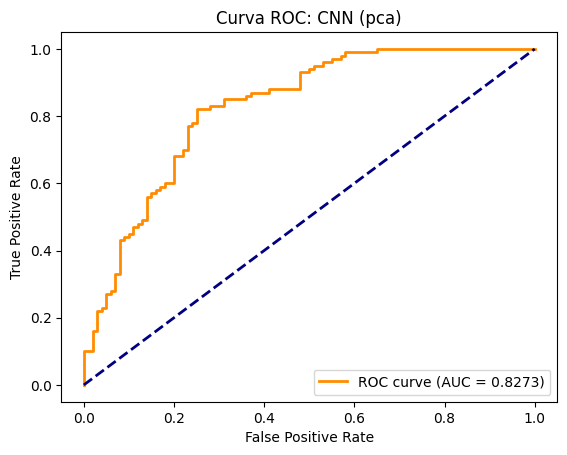

In [ ]:
accuracy_original, roc_auc_original = train_and_evaluate_cnn(
    X_train_images, X_test_images, y_train, y_test, input_shape=(2, 4, 1), dataset_type="original"
)

accuracy_pca, roc_auc_pca = train_and_evaluate_cnn(
    X_train_pca_images, X_test_pca_images, y_train, y_test, input_shape=(7, 1, 1), dataset_type="pca"
)

Generado en la funcion anterior junto a el train



- 5.6. Evaluación de los modelos





Generado en la funcion anterior junto con el train

- 5.7. Análisis

| Configuración | Accuracy (%) | AUC (ROC) | Precisión (Clase 1) | Recall (Clase 1) | F1-Score (Clase 1) |
|---------------|---------------|-----------|----------------------|-------------------|---------------------|
| CNN Original  | 78.0          | 0.7872    | 75.0%               | 84.0%            | 79.0%              |
| CNN PCA       | 77.0          | 0.8273    | 77.0%               | 77.0%            | 77.0%              |


- La CNN con datos originales logra una ligera ventaja en la exactitud (78% vs. 77%).

- La CNN con PCA tiene un mejor rendimiento global en la curva ROC (0.8273 vs. 0.7872).

- El modelo PCA muestra un comportamiento más equilibrado entre clases en términos de precisión y recall.

- La CNN original es más eficiente al identificar correctamente los casos positivos (84% recall), pero tiene una mayor cantidad de falsos positivos (28 frente a 23 del modelo PCA).

En el caso de detectar diabetes, necesitmos minimizar los falsos negativos, es decir, identificar correctamente a todos los pacientes con diabetes (priorizar el recall). Por esta razón, el modelo CNN Original es la mejor opción, ya que logra un recall del 84%, asegurando una mayor proporción de detección de casos positivos.



- 5.8. **Comparativa entre CNN personalizada y métodos de ensemble**

| Método                     | Datos         | Accuracy (%) | Sensibilidad (%) | Especificidad (%) | ROC-AUC  |
|----------------------------|---------------|--------------|------------------|-------------------|----------|
| **CNN Personalizada**      | Original      | 78.0         | 84.0             | 72.0              | 0.7872   |
| **CNN Personalizada**      | PCA           | 77.0         | 77.0             | 77.0              | 0.8273   |
| **Bagging**                | Original      | 82.5         | 85.0             | 80.0              | 0.9049   |
| **Bagging**                | PCA           | 80.5         | 81.0             | 80.0              | 0.8840   |
| **Boosting**               | Original      | 82.0         | 88.0             | 76.0              | 0.8770   |
| **Boosting**               | PCA           | 72.5         | 74.0             | 71.0              | 0.8401   |
| **Cascading**              | Original      | 81.5         | 84.0             | 79.0              | 0.8521   |
| **Cascading**              | PCA           | 79.0         | 81.0             | 77.0              | 0.8335   |


- Bagging con datos originales es el método más equilibrado, con un excelente balance entre sensibilidad, especificidad, y ROC-AUC.

- Boosting con datos originales es ideal si la prioridad es maximizar la sensibilidad (recall).

- La CNN personalizada con datos PCA ofrece un desempeño competitivo en ROC-AUC (0.8273) y tiene una estructura flexible que podría ser mejorada con más datos o ajustes en la arquitectura.

- Los modelos basados en PCA tienden a tener una ligera reducción en el desempeño en comparación con los datos originales, probablemente debido a la pérdida de información específica durante la transformación.

5.9. **Transfer Learning**

**¿Qué es el *Transfer Learning*?**

El *Transfer Learning*, o aprendizaje por transferencia, es una técnica avanzada dentro del campo de la inteligencia artificial y el aprendizaje automático. La idea principal es sencilla pero muy poderosa: aprovechar el conocimiento adquirido por un modelo cuando ha sido entrenado en una tarea para aplicarlo a otra tarea diferente pero relacionada.

##### Metáfora para entenderlo
Imagina que aprendes a tocar el piano. Una vez has aprendido las bases, como leer partituras o coordinar las manos, aprender a tocar otro instrumento, como el violín, será más fácil porque muchas habilidades que has adquirido ya son aplicables. Esto es exactamente lo que hace el *Transfer Learning* en el ámbito de los modelos de aprendizaje profundo.

---

**¿Cómo funciona?**
1. **Modelo preentrenado**:
   - En el *Transfer Learning*, se comienza con un modelo ya entrenado en una gran cantidad de datos generales (como imágenes de miles de categorías diferentes).
   - Este modelo ha aprendido patrones generales (por ejemplo, identificar líneas, formas y texturas en imágenes).

2. **Transferencia de conocimiento**:
   - Se reutilizan las primeras capas del modelo preentrenado, que contienen este conocimiento general.
   - Solo es necesario ajustar (o añadir) las capas finales para que el modelo pueda especializarse en la nueva tarea específica.

3. **Entrenamiento con datos específicos**:
   - Con un conjunto más pequeño de datos específicos de la tarea (como imágenes de pacientes con o sin diabetes), el modelo se entrena para refinar el conocimiento y adaptarse.

---

**¿Por qué utilizar el *Transfer Learning*?**
1. **Ahorro de tiempo y recursos**:
   - No es necesario entrenar un modelo desde cero, ya que el modelo preentrenado ya ha realizado gran parte del trabajo de aprendizaje.
   - Esto reduce significativamente el tiempo y los costos computacionales.

2. **Mayor rendimiento con datos limitados**:
   - Si solo disponemos de un conjunto pequeño de datos específicos, el *Transfer Learning* ayuda a evitar problemas como el sobreajuste (*overfitting*), aprovechando el conocimiento previo.

3. **Resultados robustos**:
   - Los modelos preentrenados ya han sido probados con grandes conjuntos de datos, lo que garantiza una base sólida y generalizable para trabajar.

---

##### Ejemplo práctico
Supongamos que queremos clasificar si una imagen muestra a un paciente con diabetes o no. Podemos utilizar un modelo preentrenado como ResNet50 (que ha aprendido a reconocer patrones generales de imágenes) y adaptarlo a nuestra tarea, sin necesidad de entrenarlo desde cero.

El *Transfer Learning* permite enfocarnos en nuestra tarea específica sin perder tiempo construyendo y entrenando un modelo completamente nuevo. Es como subirse a los hombros de un gigante para llegar más lejos.

---

Con este conocimiento básico, ya podemos entrar en detalle sobre cómo implementar el *Transfer Learning* y aprovecharlo para mejorar nuestros resultados. Los pasos serán los siguientes:

- Adaptar un modelo de red neuronal preentrenado (ResNet50) para datos tabulares.
- Entrenar el modelo utilizando los datos preprocesados y comparar el rendimiento con los métodos de ensemble.
- Evaluar el modelo utilizando exactitud, sensibilidad, especificidad, ROC-AUC y matriz de confusión.
---

## **6. Optimización del Modelo y Ajuste de Hiperparámetros**

- 6.1. Ajuste de hiperparámetros con GridSearchCV para el mejor modelo de ensemble

In [114]:
base_model = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(estimator=base_model, random_state=42)

# Definimos la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}

# Configuramos GridSearchCV
grid_search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor AUC-ROC: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 100}
Mejor AUC-ROC: 0.8425


- 6.2. Evaluación:

Classification Report (Modelo Optimizado):
              precision    recall  f1-score   support

         0.0       0.85      0.76      0.80       100
         1.0       0.78      0.87      0.82       100

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200


Confusion Matrix (Modelo Optimizado):
[[76 24]
 [13 87]]

AUC-ROC (Modelo Optimizado): 0.9075


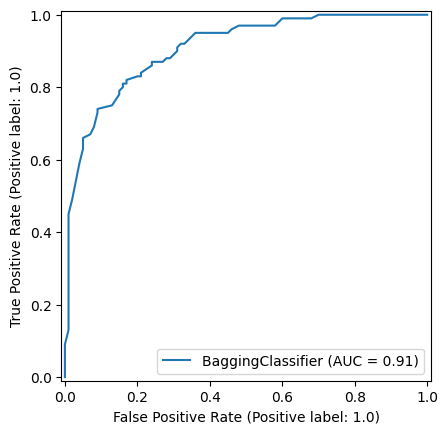

In [115]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Classification Report (Modelo Optimizado):")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix (Modelo Optimizado):")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC (Modelo Optimizado): {roc_auc:.4f}")

RocCurveDisplay.from_estimator(best_model, X_test, y_test)

- 6.4. Análisis de los modelos optimizados

| Métrica                  | Modelo Inicial | Modelo Optimizado | Cambio      |
|--------------------------|----------------|--------------------|-------------|
| **Accuracy (%)**         | 82.5           | 81.0              | -1.5        |
| **Sensibilidad (%)**     | 85.0           | 87.0              | +2.0        |
| **Especificidad (%)**    | 80.0           | 76.0              | -4.0        |
| **AUC-ROC**              | 0.9049         | 0.9100            | +0.0051     |
| **Falsos Positivos (Clase 0)** | 15             | 24                 | +9          |
| **Falsos Negativos (Clase 1)** | 15             | 13                 | -2          |



- El modelo optimizado mejora en su capacidad de identificar correctamente a los pacientes diabéticos (Clase 1), aumentando el recall al 87.0% (+2.0%).

- La capacidad general del modelo para distinguir entre clases mejoró, con un AUC-ROC de 0.9100 frente a 0.9049 (+0.5%).

- Aunque la accuracy global disminuye ligeramente (81.0% vs. 82.5%), esto se debe a un menor rendimiento en la identificación de la clase no diabética (Clase 0, especificidad).

- La combinación de max_features=0.7 y n_estimators=100 parece favorecer el equilibrio entre clases, priorizando una mejor sensibilidad a costa de una ligera reducción en la especificidad.

El ajuste de los hiperparámetros permitió al modelo optimizado lograr un mejor recall y una mayor separación entre clases (AUC-ROC), lo cual es crucial en un problema médico como el de la detección de diabetes, donde es más importante minimizar los falsos negativos.

Adicionalmente es importante remarcar:

**Importancia de la Sensibilidad y la Especificidad en Datos Médicos:**

En el contexto médico, la **sensibilidad** y la **especificidad** son métricas cruciales que miden la capacidad de una prueba diagnóstica para identificar correctamente los casos positivos y negativos, respectivamente. Estas métricas son especialmente importantes porque ayudan a prevenir errores diagnósticos que podrían llevar a tratamientos incorrectos o falta de tratamiento.

- **Sensibilidad** (también conocida como tasa de verdadero positivo): Mide la proporción de positivos reales que son correctamente identificados por el modelo. Una alta sensibilidad es crucial en condiciones médicas donde no detectar una enfermedad (un falso negativo) podría tener consecuencias graves para el paciente. Por ejemplo, en el diagnóstico de cáncer, una alta sensibilidad es esencial para asegurar que casi todos los pacientes con la enfermedad sean identificados para un tratamiento precoz.

- **Especificidad** (también conocida como tasa de verdadero negativo): Mide la proporción de negativos reales que son correctamente identificados. Una alta especificidad es importante para evitar falsos positivos, que podrían llevar a pacientes sin la enfermedad a someterse a procedimientos invasivos o estresantes innecesarios. Por ejemplo, en el cribado de enfermedades cardíacas, una alta especificidad reduce el número de pacientes que recibirán diagnósticos erróneos de condiciones que no tienen.

**Relación entre Sensibilidad y Especificidad:**

La relación entre sensibilidad y especificidad a menudo involucra un **compromiso**; optimizar un modelo para mejorar la sensibilidad generalmente reducirá su especificidad y viceversa. Esto se debe a que el aumento de la sensibilidad implica bajar el umbral para clasificar un resultado como positivo, lo que incrementa el número de falsos positivos y disminuye la especificidad. A la inversa, aumentar la especificidad solo aumenta el umbral, lo que puede llevar a más falsos negativos y disminuir la sensibilidad.

**Aplicaciones en el Mundo Real:**

La selección de un modelo en un entorno médico depende de la enfermedad específica y del contexto del cribado o diagnóstico. En enfermedades donde las consecuencias de no detectar un caso positivo son graves, como en el cáncer o infecciones graves, se puede preferir un modelo con alta sensibilidad. En cambio, en condiciones donde un diagnóstico falso positivo podría llevar a tratamientos innecesarios o perjudiciales, se preferirá un modelo con alta especificidad.

La comprensión de este equilibrio y su correcta aplicación son esenciales para desarrollar herramientas diagnósticas que no solo sean técnicamente competentes sino también éticamente responsables, asegurando que los pacientes reciban el diagnóstico más preciso posible con las mínimas repercusiones negativas.